## OpenLane Colab

This Google Colab notebook will:
* Install OpenLane and its dependencies
* Run a simple design, namely a serial-parallel multiplier, through the flow
  and targeting the [open source sky130 PDK](https://github.com/google/skywater-pdk/)
  by Google and Skywater.

In [1]:
# @title Install Nix {display-mode: "form"}
# @markdown <img src="https://raw.githubusercontent.com/NixOS/nixos-artwork/master/logo/nix-snowflake.svg" width="32"/>
# @markdown
# @markdown Nix is a package manager with an emphasis on reproducible builds,
# @markdown and it is the primary method for installing OpenLane 2.
import os

%env LOCALE_ARCHIVE=/usr/lib/locale/locale-archive
!sh <(curl -L https://nixos.org/nix/install) --daemon --yes
%env PATH=/nix/var/nix/profiles/default/bin/:{os.getenv("PATH")}
!nix-env -iA cachix -f https://cachix.org/api/v1/install
!USER=root cachix use openlane

env: LOCALE_ARCHIVE=/usr/lib/locale/locale-archive
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4052  100  4052    0     0   7784      0 --:--:-- --:--:-- --:--:--  304k
downloading Nix 2.18.1 binary tarball for x86_64-linux from 'https://releases.nixos.org/nix/nix-2.18.1/nix-2.18.1-x86_64-linux.tar.xz' to '/tmp/nix-binary-tarball-unpack.dvh6XuaZhk'...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.6M  100 20.6M    0     0  66.6M      0 --:--:-- --:--:-- --:--:-- 66.8M
Note: a multi-user installation is possible. See https://nixos.org/manual/nix/stable/installation/installing-binary.html#multi-user-installation
Switching to the Multi-user Installer
Welcome to the Multi-User Ni

In [2]:
# @title Get OpenLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install OpenLane.
# @markdown
# @markdown This will install OpenLane's tool dependencies using Nix,
# @markdown and OpenLane itself using PIP.

openlane_version = "latest"  # @param {key:"OpenLane Version", type:"string"}

if openlane_version == "latest":
    openlane_version = "main"

!curl -L "https://github.com/efabless/openlane2/tarball/{main}" | tar -xzC . --strip-components 1
tool_derivations = [
    "klayout.nix",
    "magic.nix",
    "netgen.nix",
    "openroad.nix",
    "yosys.nix",
]
for derivation in tool_derivations:
    !nix-env -i -f ./nix/{derivation}
!pip3 install -r ./requirements.txt
!volare enable $(cat ./openlane/open_pdks_rev)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9415k    0 9415k    0     0  11.2M      0 --:--:-- --:--:-- --:--:-- 11.2M
installing 'klayout-6a36bfa7c04f55bd732f8e0f91b553c8f9cebed7'
these 205 paths will be fetched (198.69 MiB download, 850.18 MiB unpacked):
  /nix/store/305gzzac3s0gign6cg6fb43z94am0s17-acl-2.3.1
  /nix/store/0lnrh5y7ybsz279sn0h9ik5fmgzwzmqz-alsa-lib-1.2.7.2
  /nix/store/y93jis2i43jc86gzw7750a2zg71y2yv8-alsa-topology-conf-1.2.5.1
  /nix/store/lj28cyzhd7wc03dlk8mab9ca5sjjnw43-alsa-ucm-conf-1.2.7.1
  /nix/store/2vx8agvw4600vjjiaci61mfvm0jndnl6-at-spi2-core-2.46.0
  /nix/store/2zr7ayk7b65wn7f8ccwxq814siafmawr-attr-2.5.1
  /nix/store/4q059vhyc419r96qskj6r1hw53w7gi69-audit-2.8.5
  /nix/store/f6s8yxj8ykdmsz0s2nfvr6gkz48g67c3-avahi-0.8
  /nix/store/wim4mqpn8lxhhr10p2kd070hyj152lil-bas

In [3]:
import openlane

print(openlane.__version__)

2.0.0b15


### Creating the design

Now that OpenLane is set up, we can write a Verilog file as follows:

In [4]:
%%writefile spm.v
module spm(clk, rst, x, y, p);
    parameter size = 32;
    input clk, rst;
    input y;
    input[size-1:0] x;
    output p;

    wire[size-1:1] pp;
    wire[size-1:0] xy;

    genvar i;

    CSADD csa0 (.clk(clk), .rst(rst), .x(x[0]&y), .y(pp[1]), .sum(p));
    generate for(i=1; i<size-1; i=i+1) begin
        CSADD csa (.clk(clk), .rst(rst), .x(x[i]&y), .y(pp[i+1]), .sum(pp[i]));
    end endgenerate
    TCMP tcmp (.clk(clk), .rst(rst), .a(x[size-1]&y), .s(pp[size-1]));

endmodule

module TCMP(clk, rst, a, s);
    input clk, rst;
    input a;
    output reg s;

    reg z;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            //Reset logic goes here.
            s <= 1'b0;
            z <= 1'b0;
        end
        else begin
            //Sequential logic goes here.
            z <= a | z;
            s <= a ^ z;
        end
    end
endmodule

module CSADD(clk, rst, x, y, sum);
    input clk, rst;
    input x, y;
    output reg sum;

    reg sc;

    // Half Adders logic
    wire hsum1, hco1;
    assign hsum1 = y ^ sc;
    assign hco1 = y & sc;

    wire hsum2, hco2;
    assign hsum2 = x ^ hsum1;
    assign hco2 = x & hsum1;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            //Reset logic goes here.
            sum <= 1'b0;
            sc <= 1'b0;
        end
        else begin
            //Sequential logic goes here.
            sum <= hsum2;
            sc <= hco1 ^ hco2;
        end
    end
endmodule

Writing spm.v


### Setting up the configuration

OpenLane requries you to configure any Flow before using it. This is done using
the `config` module.

For colaboratories, REPLs and other interactive environments where there is no
concrete Flow object, the Configuration may be initialized using `Config.interactive`,
which will automatically propagate the configuration to any future steps.

You can find the documentation for `Config.interactive` [here](https://openlane2.readthedocs.io/en/latest/reference/api/config/index.html#openlane.config.Config.interactive).



In [5]:
from openlane.config import Config

Config.interactive(
    "spm",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=10,
    PRIMARY_SIGNOFF_TOOL="klayout",
)


### Interactive Configuration
#### Initial Values

<br />

```yml
CELL_BB_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox_pp.v
CELL_GDS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
CELL_LEFS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef
CELL_PAD_EXCLUDE:
- sky130_fd_sc_hd__tap*
- sky130_fd_sc_hd__decap*
- sky130_ef_sc_hd__decap*
- sky130_fd_sc_hd__fill*
CELL_SPICE_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fakediode_2.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
CELL_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/primitives.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd.v
CHECK_ASSIGN_STATEMENTS: false
CLOCK_NET: clk
CLOCK_PERIOD: 10
CLOCK_PORT: clk
CLOCK_TRANSITION_CONSTRAINT: 0.15
CLOCK_UNCERTAINTY_CONSTRAINT: 0.25
CLOCK_WIRE_RC_LAYER: met5
CTS_CLK_BUFFERS:
- sky130_fd_sc_hd__clkbuf_8
- sky130_fd_sc_hd__clkbuf_4
- sky130_fd_sc_hd__clkbuf_2
CTS_MAX_CAP: 1.53169
CTS_ROOT_BUFFER: sky130_fd_sc_hd__clkbuf_16
DATA_WIRE_RC_LAYER: met2
DECAP_CELL:
- sky130_fd_sc_hd__decap_8
- sky130_fd_sc_hd__decap_6
- sky130_fd_sc_hd__decap_4
- sky130_fd_sc_hd__decap_3
DEFAULT_CORNER: nom_tt_025C_1v80
DEFAULT_MAX_TRAN: null
DESIGN_DIR: .
DESIGN_NAME: spm
DIE_AREA: null
DIODE_CELL: sky130_fd_sc_hd__diode_2/DIODE
DPL_CELL_PADDING: 0
EXTRA_GDS_FILES: null
EXTRA_LEFS: null
EXTRA_LIBS: null
EXTRA_SPICE_MODELS: null
EXTRA_VERILOG_MODELS: null
FALLBACK_SDC_FILE: /content/openlane/scripts/base.sdc
FILL_CELL:
- sky130_fd_sc_hd__fill*
FP_CONTEXT_DEF: null
FP_CONTEXT_LEF: null
FP_ENDCAP_CELL: sky130_fd_sc_hd__decap_3
FP_IO_HLAYER: met3
FP_IO_VLAYER: met2
FP_PADFRAME_CFG: null
FP_TAPCELL_DIST: 13
FP_TRACKS_INFO: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tracks.info
FP_WELLTAP_CELL: sky130_fd_sc_hd__tapvpwrvgnd_1
GND_NETS: null
GND_PIN: VGND
GPIO_PADS_LEF:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_fd_io.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_ef_io.lef
GPIO_PADS_LEF_CORE_SIDE:
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_fd_io_core.lef
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_ef_io_core.lef
GPIO_PADS_PREFIX:
- sky130_fd_io
- sky130_ef_io
GPIO_PADS_VERILOG:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/verilog/sky130_ef_io.v
GPL_CELL_PADDING: 0
GRT_LAYER_ADJUSTMENTS:
- 0.99
- 0
- 0
- 0
- 0
- 0
GRT_OBS: null
IGNORE_DISCONNECTED_MODULES:
- sky130_fd_sc_hd__conb_1
IO_DELAY_CONSTRAINT: 20
LEC_ENABLE: false
LIB:
  '*_ff_n40C_1v95':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib
  '*_ss_100C_1v60':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib
  '*_tt_025C_1v80':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
LVS_INSERT_POWER_PINS: true
MACROS: null
MAX_FANOUT_CONSTRAINT: 10
MAX_TRANSITION_CONSTRAINT: 0.75
OUTPUT_CAP_LOAD: 33.442
PDK: sky130A
PDK_ROOT: /root/.volare
PLACE_SITE: unithd
PLACE_SITE_HEIGHT: 2.72
PLACE_SITE_WIDTH: 0.46
PNR_EXCLUSION_CELL_LIST: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/drc_exclude.cells
PRIMARY_SIGNOFF_TOOL: klayout
RT_MAX_LAYER: met5
RT_MIN_LAYER: met1
RUN_CVC: true
SCL_GROUND_PINS:
- VGND
- VNB
SCL_POWER_PINS:
- VPWR
- VPB
STA_CORNERS:
- nom_tt_025C_1v80
- nom_ss_100C_1v60
- nom_ff_n40C_1v95
- min_tt_025C_1v80
- min_ss_100C_1v60
- min_ff_n40C_1v95
- max_tt_025C_1v80
- max_ss_100C_1v60
- max_ff_n40C_1v95
STD_CELL_LIBRARY: sky130_fd_sc_hd
SYNTH_BUFFER_CELL: sky130_fd_sc_hd__buf_2/A/X
SYNTH_CLK_DRIVING_CELL: null
SYNTH_DRIVING_CELL: sky130_fd_sc_hd__inv_2/Y
SYNTH_EXCLUSION_CELL_LIST: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/no_synth.cells
SYNTH_TIEHI_CELL: sky130_fd_sc_hd__conb_1/HI
SYNTH_TIELO_CELL: sky130_fd_sc_hd__conb_1/LO
TECH_LEFS:
  max_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__max.tlef
  min_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__min.tlef
  nom_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
TIME_DERATING_CONSTRAINT: 5
VDD_NETS: null
VDD_PIN: VPWR
VDD_PIN_VOLTAGE: 1.8
WIRE_LENGTH_THRESHOLD: null
meta:
  flow: null
  openlane_version: 2.0.0b15
  step: null
  version: 1

```


### Running implementation steps

There are two ways to obtain OpenLane's built-in implementation steps:

* via directly importing from the `steps` module using its category:
    * `from openlane.steps import Yosys` then `Synthesis = Yosys.Synthesis`
* by using the step's id from the registry:
    * `from openlane.steps import Step` then `Synthesis = Step.factory.get("Yosys.Synthesis")`

You can find a full list of included steps here: https://openlane2.readthedocs.io/en/latest/reference/step_config_vars.html

In [6]:
from openlane.steps import Step

* First, get the step (and display its help)...

In [7]:
Synthesis = Step.factory.get("Yosys.Synthesis")

Synthesis.display_help()


### Synthesis

<a name="yosys.synthesis"></a>

```{eval-rst}

Performs synthesis and technology mapping on Verilog RTL files
using Yosys and ABC, emitting a netlist.

Some metrics will also be extracted and updated, namely:

* ``design__instance__count``
* ``design__instance_unmapped__count``
* ``design__instance__area``

```

#### Importing
```python
from openlane.steps.yosys import Synthesis

# or

from openlane.steps import Step

Synthesis = Step.factory.get("Yosys.Synthesis")
```


#### Inputs and Outputs

| Inputs | Outputs |
| - | - |
|  | Verilog Netlist (.nl.v) |
#### Configuration Variables

| Variable Name | Type | Description | Default | Units |
| - | - | - | - | - |
| <a name="yosys.synthesis.synth_latch_map"></a>`SYNTH_LATCH_MAP`<sup>PDK</sup> | Path? | A path to a file contianing the latch mapping for Yosys. | `None` |  |
| <a name="yosys.synthesis.synth_tristate_map"></a>`SYNTH_TRISTATE_MAP`<sup>PDK</sup> | Path? | A path to a file contianing the tri-state buffer mapping for Yosys. | `None` |  |
| <a name="yosys.synthesis.synth_csa_map"></a>`SYNTH_CSA_MAP`<sup>PDK</sup> | Path? | A path to a file containing the carry-select adder mapping for Yosys. | `None` |  |
| <a name="yosys.synthesis.synth_rca_map"></a>`SYNTH_RCA_MAP`<sup>PDK</sup> | Path? | A path to a file containing the ripple-carry adder mapping for Yosys. | `None` |  |
| <a name="yosys.synthesis.synth_fa_map"></a>`SYNTH_FA_MAP`<sup>PDK</sup> | Path? | A path to a file containing the full adder mapping for Yosys. | `None` |  |
| <a name="yosys.synthesis.synth_mux_map"></a>`SYNTH_MUX_MAP`<sup>PDK</sup> | Path? | A path to a file containing the mux mapping for Yosys. | `None` |  |
| <a name="yosys.synthesis.synth_mux4_map"></a>`SYNTH_MUX4_MAP`<sup>PDK</sup> | Path? | A path to a file containing the mux4 mapping for Yosys. | `None` |  |
| <a name="yosys.synthesis.use_lighter"></a>`USE_LIGHTER` | bool | Activates Lighter, an experimental plugin that attempts to optimize clock-gated flip-flops. | `False` |  |
| <a name="yosys.synthesis.lighter_dff_map"></a>`LIGHTER_DFF_MAP` | Path? | An override to the custom DFF map file provided for the given SCL by Lighter. | `None` |  |
| <a name="yosys.synthesis.synth_checks_allow_tristate"></a>`SYNTH_CHECKS_ALLOW_TRISTATE` | bool | Ignore multiple-driver warnings if they are connected to tri-state buffers on a best-effort basis. | `True` |  |
| <a name="yosys.synthesis.synth_autoname"></a>`SYNTH_AUTONAME` | bool | Generates names for netlist instances. This results in instance names that can be extremely long, but are more human-readable. | `False` |  |
| <a name="yosys.synthesis.synth_strategy"></a>`SYNTH_STRATEGY` | 'AREA 0'｜'AREA 1'｜'AREA 2'｜'AREA 3'｜'AREA 4'｜'DELAY 0'｜'DELAY 1'｜'DELAY 2'｜'DELAY 3'｜'DELAY 4' | Strategies for abc logic synthesis and technology mapping. AREA strategies usually result in a more compact design, while DELAY strategies usually result in a design that runs at a higher frequency. Please note that there is no way to know which strategy is the best before trying them. | `AREA 0` |  |
| <a name="yosys.synthesis.synth_abc_buffering"></a>`SYNTH_ABC_BUFFERING` | bool | Enables `abc` cell buffering. | `True` |  |
| <a name="yosys.synthesis.synth_direct_wire_buffering"></a>`SYNTH_DIRECT_WIRE_BUFFERING` | bool | Enables inserting buffer cells for directly connected wires. | `True` |  |
| <a name="yosys.synthesis.synth_splitnets"></a>`SYNTH_SPLITNETS` | bool | Splits multi-bit nets into single-bit nets. Easier to trace but may not be supported by all tools. | `True` |  |
| <a name="yosys.synthesis.synth_sizing"></a>`SYNTH_SIZING` | bool | Enables `abc` cell sizing (instead of buffering). | `False` |  |
| <a name="yosys.synthesis.synth_no_flat"></a>`SYNTH_NO_FLAT` | bool | A flag that disables flattening the hierarchy during synthesis, only flattening it after synthesis, mapping and optimizations. | `False` |  |
| <a name="yosys.synthesis.synth_share_resources"></a>`SYNTH_SHARE_RESOURCES` | bool | A flag that enables yosys to reduce the number of cells by determining shareable resources and merging them. | `True` |  |
| <a name="yosys.synthesis.synth_adder_type"></a>`SYNTH_ADDER_TYPE` | 'YOSYS'｜'FA'｜'RCA'｜'CSA' | Adder type to which the $add and $sub operators are mapped to.  Possible values are `YOSYS/FA/RCA/CSA`; where `YOSYS` refers to using Yosys internal adder definition, `FA` refers to full-adder structure, `RCA` refers to ripple carry adder structure, and `CSA` refers to carry select adder. | `YOSYS` |  |
| <a name="yosys.synthesis.synth_extra_mapping_file"></a>`SYNTH_EXTRA_MAPPING_FILE` | Path? | Points to an extra techmap file for yosys that runs right after yosys `synth` before generic techmap. | `None` |  |
| <a name="yosys.synthesis.synth_parameters"></a>`SYNTH_PARAMETERS` | List[str]? | Key-value pairs to be `chparam`ed in Yosys, in the format `key1=value1`. | `None` |  |
| <a name="yosys.synthesis.synth_elaborate_only"></a>`SYNTH_ELABORATE_ONLY` | bool | "Elaborate" the design only without attempting any logic mapping. Useful when dealing with structural Verilog netlists. | `False` |  |
| <a name="yosys.synthesis.synth_elaborate_flatten"></a>`SYNTH_ELABORATE_FLATTEN` | bool | If `SYNTH_ELABORATE_ONLY` is specified, this variable controls whether or not the top level should be flattened. | `True` |  |
| <a name="yosys.synthesis.verilog_files"></a>`VERILOG_FILES` | List[Path] | The paths of the design's Verilog files. | `None` |  |
| <a name="yosys.synthesis.verilog_defines"></a>`VERILOG_DEFINES` | List[str]? | Preprocessor defines for input Verilog files. | `None` |  |
| <a name="yosys.synthesis.verilog_power_define"></a>`VERILOG_POWER_DEFINE` | str? | Specifies the name of the define used to guard power and ground connections | `None` |  |
| <a name="yosys.synthesis.verilog_include_dirs"></a>`VERILOG_INCLUDE_DIRS` | List[str]? | Specifies the Verilog `include` directories. | `None` |  |
| <a name="yosys.synthesis.use_synlig"></a>`USE_SYNLIG` | bool | Use the Synlig plugin to process files, which has better SystemVerilog parsing capabilities but may not be compatible with all Yosys commands and attributes. | `False` |  |
| <a name="yosys.synthesis.synlig_defer"></a>`SYNLIG_DEFER` | bool | Uses -defer flag when reading files the Synlig plugin, which may improve performance by reading each file separately, but is experimental. | `False` |  |



* Then run it. Note you can pass step-specific configs using Python keyword
  arguments.

In [8]:
synthesis = Synthesis(
    VERILOG_FILES=["./spm.v"],
)
synthesis.start()

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

/----------------------------------------------------------------------------\

|                                                                            |

|  yosys -- Yosys Open SYnthesis Suite                                       |

|                                                                            |

|  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |

|                                                                            |

|  Permission to use, copy, modify, and/or distribute this software for any  |

|  purpose with or without fee is hereby granted, provided that the above    |

|  copyright notice and this permission notice appear in all copies.         |

|                                                                            |

|  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |

|  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |

|  MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR   |

|  ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES    |

|  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN     |

|  ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF   |

|  OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.            |

|                                                                            |

\----------------------------------------------------------------------------/

Yosys 0.34 (git sha1 4a1b5599258, clang++ 11.1.0 -fPIC -Os)

[TCL: yosys -import] Command name collision: found pre-existing command `cd' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `eval' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `exec' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `read' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `trace' -> skip.

Reading SCL library '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib' as a 
blackboxâ¦

1. Executing Liberty frontend: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib

Imported 428 cell types from liberty file.

2. Executing Verilog-2005 frontend: ./spm.v

Parsing SystemVerilog input from `./spm.v' to AST representation.

Generating RTLIL representation for module `\spm'.

Generating RTLIL representation for module `\TCMP'.

Generating RTLIL representation for module `\CSADD'.

Successfully finished Verilog frontend.

3. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/1-yosys-synthesis/hierarchy.dot'.

Dumping module spm to page 1.

4. Executing HIERARCHY pass (managing design hierarchy).

4.1. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

4.2. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

Removed 0 unused modules.

Renaming module spm to spm.

5. Executing HIERARCHY pass (managing design hierarchy).

5.1. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

5.2. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

Removed 0 unused modules.

6. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Cleaned up 0 empty switches.

7. Executing PROC_RMDEAD pass (remove dead branches from decision trees).

Marked 1 switch rules as full_case in process $proc$./spm.v:28$33 in module TCMP.

Marked 1 switch rules as full_case in process $proc$./spm.v:58$40 in module CSADD.

Removed a total of 0 dead cases.

8. Executing PROC_PRUNE pass (remove redundant assignments in processes).

Removed 4 redundant assignments.

Promoted 0 assignments to connections.

9. Executing PROC_INIT pass (extract init attributes).

10. Executing PROC_ARST pass (detect async resets in processes).

Found async reset \rst in `\TCMP.$proc$./spm.v:28$33'.

Found async reset \rst in `\CSADD.$proc$./spm.v:58$40'.

11. Executing PROC_ROM pass (convert switches to ROMs).

Converted 0 switches.

12. Executing PROC_MUX pass (convert decision trees to multiplexers).

Creating decoders for process `\TCMP.$proc$./spm.v:28$33'.

1/2: $0\s[0:0]

2/2: $0\z[0:0]

Creating decoders for process `\CSADD.$proc$./spm.v:58$40'.

1/2: $0\sc[0:0]

2/2: $0\sum[0:0]

13. Executing PROC_DLATCH pass (convert process syncs to latches).

14. Executing PROC_DFF pass (convert process syncs to FFs).

Creating register for signal `\TCMP.\s' using process `\TCMP.$proc$./spm.v:28$33'.

created $adff cell `$procdff$42' with positive edge clock and positive level reset.

Creating register for signal `\TCMP.\z' using process `\TCMP.$proc$./spm.v:28$33'.

created $adff cell `$procdff$43' with positive edge clock and positive level reset.

Creating register for signal `\CSADD.\sum' using process `\CSADD.$proc$./spm.v:58$40'.

created $adff cell `$procdff$44' with positive edge clock and positive level reset.

Creating register for signal `\CSADD.\sc' using process `\CSADD.$proc$./spm.v:58$40'.

created $adff cell `$procdff$45' with positive edge clock and positive level reset.

15. Executing PROC_MEMWR pass (convert process memory writes to cells).

16. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Removing empty process `TCMP.$proc$./spm.v:28$33'.

Removing empty process `CSADD.$proc$./spm.v:58$40'.

Cleaned up 0 empty switches.

17. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Checking module TCMP...

Checking module CSADD...

Found and reported 0 problems.

18. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

Optimizing module TCMP.

Optimizing module CSADD.

19. Executing FLATTEN pass (flatten design).

Deleting now unused module TCMP.

Deleting now unused module CSADD.

<suppressed ~32 debug messages>

20. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

21. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 221 unused wires.

<suppressed ~2 debug messages>

22. Executing OPT pass (performing simple optimizations).

22.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

22.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

22.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

22.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

22.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

22.6. Executing OPT_DFF pass (perform DFF optimizations).

22.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

22.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

22.9. Finished OPT passes. (There is nothing left to do.)

23. Executing FSM pass (extract and optimize FSM).

23.1. Executing FSM_DETECT pass (finding FSMs in design).

23.2. Executing FSM_EXTRACT pass (extracting FSM from design).

23.3. Executing FSM_OPT pass (simple optimizations of FSMs).

23.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

23.5. Executing FSM_OPT pass (simple optimizations of FSMs).

23.6. Executing FSM_RECODE pass (re-assigning FSM state encoding).

23.7. Executing FSM_INFO pass (dumping all available information on FSM cells).

23.8. Executing FSM_MAP pass (mapping FSMs to basic logic).

24. Executing OPT pass (performing simple optimizations).

24.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

24.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

24.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

24.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

24.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

24.6. Executing OPT_DFF pass (perform DFF optimizations).

24.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

24.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

24.9. Finished OPT passes. (There is nothing left to do.)

25. Executing WREDUCE pass (reducing word size of cells).

26. Executing PEEPOPT pass (run peephole optimizers).

27. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

28. Executing ALUMACC pass (create $alu and $macc cells).

Extracting $alu and $macc cells in module spm:

created 0 $alu and 0 $macc cells.

29. Executing SHARE pass (SAT-based resource sharing).

30. Executing OPT pass (performing simple optimizations).

30.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

30.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

30.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

30.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

30.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

30.6. Executing OPT_DFF pass (perform DFF optimizations).

30.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

30.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

30.9. Finished OPT passes. (There is nothing left to do.)

31. Executing MEMORY pass.

31.1. Executing OPT_MEM pass (optimize memories).

Performed a total of 0 transformations.

31.2. Executing OPT_MEM_PRIORITY pass (removing unnecessary memory write priority relations).

Performed a total of 0 transformations.

31.3. Executing OPT_MEM_FEEDBACK pass (finding memory read-to-write feedback paths).

31.4. Executing MEMORY_BMUX2ROM pass (converting muxes to ROMs).

31.5. Executing MEMORY_DFF pass (merging $dff cells to $memrd).

31.6. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

31.7. Executing MEMORY_SHARE pass (consolidating $memrd/$memwr cells).

31.8. Executing OPT_MEM_WIDEN pass (optimize memories where all ports are wide).

Performed a total of 0 transformations.

31.9. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

31.10. Executing MEMORY_COLLECT pass (generating $mem cells).

32. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

33. Executing OPT pass (performing simple optimizations).

33.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

33.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

33.3. Executing OPT_DFF pass (perform DFF optimizations).

33.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

33.5. Finished fast OPT passes.

34. Executing MEMORY_MAP pass (converting memories to logic and flip-flops).

35. Executing OPT pass (performing simple optimizations).

35.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

35.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

35.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

35.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

35.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

35.6. Executing OPT_SHARE pass.

35.7. Executing OPT_DFF pass (perform DFF optimizations).

35.8. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

35.9. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

35.10. Finished OPT passes. (There is nothing left to do.)

36. Executing TECHMAP pass (map to technology primitives).

36.1. Executing Verilog-2005 frontend: 
/nix/store/9gvg4b4jw2xg04h7sq5zgxymrm4ja31v-yosys/bin/../share/yosys/techmap.v

Parsing Verilog input from `/nix/store/9gvg4b4jw2xg04h7sq5zgxymrm4ja31v-yosys/bin/../share/yosys/techmap.v' to AST 
representation.

Generating RTLIL representation for module `\_90_simplemap_bool_ops'.

Generating RTLIL representation for module `\_90_simplemap_reduce_ops'.

Generating RTLIL representation for module `\_90_simplemap_logic_ops'.

Generating RTLIL representation for module `\_90_simplemap_compare_ops'.

Generating RTLIL representation for module `\_90_simplemap_various'.

Generating RTLIL representation for module `\_90_simplemap_registers'.

Generating RTLIL representation for module `\_90_shift_ops_shr_shl_sshl_sshr'.

Generating RTLIL representation for module `\_90_shift_shiftx'.

Generating RTLIL representation for module `\_90_fa'.

Generating RTLIL representation for module `\_90_lcu'.

Generating RTLIL representation for module `\_90_alu'.

Generating RTLIL representation for module `\_90_macc'.

Generating RTLIL representation for module `\_90_alumacc'.

Generating RTLIL representation for module `\$__div_mod_u'.

Generating RTLIL representation for module `\$__div_mod_trunc'.

Generating RTLIL representation for module `\_90_div'.

Generating RTLIL representation for module `\_90_mod'.

Generating RTLIL representation for module `\$__div_mod_floor'.

Generating RTLIL representation for module `\_90_divfloor'.

Generating RTLIL representation for module `\_90_modfloor'.

Generating RTLIL representation for module `\_90_pow'.

Generating RTLIL representation for module `\_90_pmux'.

Generating RTLIL representation for module `\_90_demux'.

Generating RTLIL representation for module `\_90_lut'.

Successfully finished Verilog frontend.

36.2. Continuing TECHMAP pass.

Using extmapper simplemap for cells of type $and.

Using extmapper simplemap for cells of type $adff.

Using extmapper simplemap for cells of type $xor.

Using extmapper simplemap for cells of type $or.

No more expansions possible.

<suppressed ~326 debug messages>

37. Executing OPT pass (performing simple optimizations).

37.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

37.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

37.3. Executing OPT_DFF pass (perform DFF optimizations).

37.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

37.5. Finished fast OPT passes.

38. Executing ABC pass (technology mapping using ABC).

38.1. Extracting gate netlist of module `\spm' to `<abc-temp-dir>/input.blif'..

Extracted 189 gates and 285 wires to a netlist network with 96 inputs and 64 outputs.

38.1.1. Executing ABC.

Running ABC command: "/nix/store/cvdwg68g71ibc2nfi1ybqzl637ads9y8-yosys-abc/bin/abc" -s -f 
<abc-temp-dir>/abc.script 2>&1

ABC: ABC command line: "source <abc-temp-dir>/abc.script".

ABC:

ABC: + read_blif <abc-temp-dir>/input.blif

ABC: + read_library <abc-temp-dir>/stdcells.genlib

ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".

ABC: + strash

ABC: + dretime

ABC: + map

ABC: + write_blif <abc-temp-dir>/output.blif

38.1.2. Re-integrating ABC results.

ABC RESULTS:                OR cells:        1

ABC RESULTS:               AND cells:       32

ABC RESULTS:              NAND cells:       31

ABC RESULTS:              XNOR cells:       31

ABC RESULTS:               NOR cells:       31

ABC RESULTS:               XOR cells:       63

ABC RESULTS:        internal signals:      125

ABC RESULTS:           input signals:       96

ABC RESULTS:          output signals:       64

Removing temp directory.

39. Executing OPT pass (performing simple optimizations).

39.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

39.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

39.3. Executing OPT_DFF pass (perform DFF optimizations).

39.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 285 unused wires.

<suppressed ~126 debug messages>

39.5. Finished fast OPT passes.

40. Executing HIERARCHY pass (managing design hierarchy).

40.1. Analyzing design hierarchy..

Top module:  \spm

40.2. Analyzing design hierarchy..

Top module:  \spm

Removed 0 unused modules.

41. Printing statistics.

=== spm ===

Number of wires:                354

Number of wire bits:            415

Number of public wires:         196

Number of public wire bits:     257

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                253

$_AND_                         32

$_DFF_PP0_                     64

$_NAND_                        31

$_NOR_                         31

$_OR_                           1

$_XNOR_                        31

$_XOR_                         63

42. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Found and reported 0 problems.

43. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/1-yosys-synthesis/post_techmap.dot'.

Dumping module spm to page 1.

44. Executing SHARE pass (SAT-based resource sharing).

45. Executing OPT pass (performing simple optimizations).

45.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

45.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

45.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

45.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

45.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

45.6. Executing OPT_DFF pass (perform DFF optimizations).

45.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

45.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

45.9. Finished OPT passes. (There is nothing left to do.)

46. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 97 unused wires.

<suppressed ~97 debug messages>

{

"creator": "Yosys 0.34 (git sha1 4a1b5599258, clang++ 11.1.0 -fPIC -Os)",

"invocation": "stat -json ",

"modules": {

"\\spm": {

"num_wires":         257,

"num_wire_bits":     288,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         253,

"num_cells_by_type": {

"$_AND_": 32,

"$_DFF_PP0_": 64,

"$_NAND_": 31,

"$_NOR_": 31,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63

}

}

},

"design": {

"num_wires":         257,

"num_wire_bits":     288,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         253,

"num_cells_by_type": {

"$_AND_": 32,

"$_DFF_PP0_": 64,

"$_NAND_": 31,

"$_NOR_": 31,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63

}

}

}

[INFO] Applying latch mapping from '/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v'â¦

47. Executing TECHMAP pass (map to technology primitives).

47.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v' to AST 
representation.

Generating RTLIL representation for module `\$_DLATCH_P_'.

Generating RTLIL representation for module `\$_DLATCH_N_'.

Successfully finished Verilog frontend.

47.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~4 debug messages>

48. Executing SIMPLEMAP pass (map simple cells to gate primitives).

49. Executing DFFLIBMAP pass (mapping DFF cells to sequential cells from liberty file).

cell sky130_fd_sc_hd__dfxtp_2 (noninv, pins=3, area=21.27) is a direct match for cell type $_DFF_P_.

cell sky130_fd_sc_hd__dfrtp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN0_.

cell sky130_fd_sc_hd__dfstp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN1_.

cell sky130_fd_sc_hd__dfbbn_2 (noninv, pins=6, area=35.03) is a direct match for cell type $_DFFSR_NNN_.

final dff cell mappings:

unmapped dff cell: $_DFF_N_

\sky130_fd_sc_hd__dfxtp_2 _DFF_P_ (.CLK( C), .D( D), .Q( Q));

unmapped dff cell: $_DFF_NN0_

unmapped dff cell: $_DFF_NN1_

unmapped dff cell: $_DFF_NP0_

unmapped dff cell: $_DFF_NP1_

\sky130_fd_sc_hd__dfrtp_2 _DFF_PN0_ (.CLK( C), .D( D), .Q( Q), .RESET_B( R));

\sky130_fd_sc_hd__dfstp_2 _DFF_PN1_ (.CLK( C), .D( D), .Q( Q), .SET_B( R));

unmapped dff cell: $_DFF_PP0_

unmapped dff cell: $_DFF_PP1_

\sky130_fd_sc_hd__dfbbn_2 _DFFSR_NNN_ (.CLK_N( C), .D( D), .Q( Q), .Q_N(~Q), .RESET_B( R), .SET_B( S));

unmapped dff cell: $_DFFSR_NNP_

unmapped dff cell: $_DFFSR_NPN_

unmapped dff cell: $_DFFSR_NPP_

unmapped dff cell: $_DFFSR_PNN_

unmapped dff cell: $_DFFSR_PNP_

unmapped dff cell: $_DFFSR_PPN_

unmapped dff cell: $_DFFSR_PPP_

49.1. Executing DFFLEGALIZE pass (convert FFs to types supported by the target).

Mapping DFF cells in module `\spm':

mapped 64 $_DFF_PN0_ cells to \sky130_fd_sc_hd__dfrtp_2 cells.

{

"creator": "Yosys 0.34 (git sha1 4a1b5599258, clang++ 11.1.0 -fPIC -Os)",

"invocation": "stat -json ",

"modules": {

"\\spm": {

"num_wires":         321,

"num_wire_bits":     352,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         317,

"num_cells_by_type": {

"$_AND_": 32,

"$_NAND_": 31,

"$_NOR_": 31,

"$_NOT_": 64,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63,

"sky130_fd_sc_hd__dfrtp_2": 64

}

}

},

"design": {

"num_wires":         321,

"num_wire_bits":     352,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         317,

"num_cells_by_type": {

"$_AND_": 32,

"$_NAND_": 31,

"$_NOR_": 31,

"$_NOT_": 64,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63,

"sky130_fd_sc_hd__dfrtp_2": 64

}

}

}

[INFO] USING STRATEGY AREA 0

50. Executing ABC pass (technology mapping using ABC).

50.1. Extracting gate netlist of module `\spm' to `/tmp/yosys-abc-QOQDcm/input.blif'..

Extracted 253 gates and 350 wires to a netlist network with 97 inputs and 128 outputs.

50.1.1. Executing ABC.

Running ABC command: "/nix/store/cvdwg68g71ibc2nfi1ybqzl637ads9y8-yosys-abc/bin/abc" -s -f 
/tmp/yosys-abc-QOQDcm/abc.script 2>&1

ABC: ABC command line: "source /tmp/yosys-abc-QOQDcm/abc.script".

ABC:

ABC: + read_blif /tmp/yosys-abc-QOQDcm/input.blif

ABC: + read_lib -w /content/openlane_run/tmp/a4689ec995ae4374805d2cd6e171b2aa.lib

ABC: Parsing finished successfully.  Parsing time =     0.28 sec

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfbbn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfsbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtp_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_8".

ABC: Library "sky130_fd_sc_hd__tt_025C_1v80" from "/content/openlane_run/tmp/a4689ec995ae4374805d2cd6e171b2aa.lib" 
has 175 cells (17 skipped: 14 seq; 3 tri-state; 0 no func; 0 dont_use).  Time =     0.46 sec

ABC: Memory =    9.54 MB. Time =     0.46 sec

ABC: Warning: Detected 2 multi-output gates (for example, "sky130_fd_sc_hd__fa_1").

ABC: + read_constr -v /content/openlane_run/1-yosys-synthesis/synthesis.sdc

ABC: Setting driving cell to be "sky130_fd_sc_hd__inv_2/Y".

ABC: Setting output load to be 33.442001.

ABC: + read_constr /content/openlane_run/1-yosys-synthesis/synthesis.sdc

ABC: + fx

ABC: + mfs

ABC: + strash

ABC: + refactor

ABC: + balance

ABC: + rewrite

ABC: + refactor

ABC: + balance

ABC: + rewrite

ABC: + rewrite -z

ABC: + balance

ABC: + refactor -z

ABC: + rewrite -z

ABC: + balance

ABC: + retime -D -D 10000 -M 5

ABC: + scleanup

ABC: Error: The network is combinational.

ABC: + fraig_store

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + rewrite

ABC: + refactor

ABC: + balance

ABC: + rewrite

ABC: + rewrite -z

ABC: + balance

ABC: + refactor -z

ABC: + rewrite -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + rewrite

ABC: + refactor

ABC: + balance

ABC: + rewrite

ABC: + rewrite -z

ABC: + balance

ABC: + refactor -z

ABC: + rewrite -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + rewrite

ABC: + refactor

ABC: + balance

ABC: + rewrite

ABC: + rewrite -z

ABC: + balance

ABC: + refactor -z

ABC: + rewrite -z

ABC: + balance

ABC: + fraig_store

ABC: + fraig_restore

ABC: + amap -m -Q 0.1 -F 20 -A 20 -C 5000

ABC: + retime -D -D 10000

ABC: + &get -n

ABC: + &st

ABC: + &dch

ABC: + &nf

ABC: + &put

ABC: + buffer -N 10 -S 750.0

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: + upsize -D 10000

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: Current delay (550.44 ps) does not exceed the target delay (10000.00 ps). Upsizing is not performed.

ABC: + dnsize -D 10000

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: + stime -p

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: WireLoad = "none"  Gates =    223 ( 29.1 %)   Cap = 19.7 ff (  3.7 %)   Area =     1976.90 ( 70.9 %)   Delay =
695.54 ps  (  1.3 %)

ABC: Path  0 --       5 : 0    2 pi                      A =   0.00  Df =   0.0   -0.0 ps  S =   0.0 ps  Cin =  0.0
ff  Cout =   7.0 ff  Cmax =   0.0 ff  G =    0

ABC: Path  1 --     231 : 3    2 sky130_fd_sc_hd__a21o_2 A =   8.76  Df = 269.1  -58.1 ps  S = 180.6 ps  Cin =  2.4
ff  Cout =  34.9 ff  Cmax = 309.5 ff  G = 1483

ABC: Path  2 --     233 : 2    1 sky130_fd_sc_hd__and2_2 A =   7.51  Df = 454.8  -79.2 ps  S =  36.3 ps  Cin =  1.5
ff  Cout =   2.2 ff  Cmax = 303.0 ff  G =  143

ABC: Path  3 --     234 : 1    1 sky130_fd_sc_hd__buf_1  A =   3.75  Df = 695.5  -26.6 ps  S = 396.3 ps  Cin =  2.1
ff  Cout =  33.4 ff  Cmax = 130.0 ff  G = 1590

ABC: Start-point = pi4 (\x [31]).  End-point = po2 ($abc$376$flatten\tcmp.$0\s[0:0]).

ABC: + print_stats -m

ABC: netlist                       : i/o =   97/  128  lat =    0  nd =   223  edge =    445  area =1977.20  delay 
= 3.00  lev = 3

ABC: + write_blif /tmp/yosys-abc-QOQDcm/output.blif

50.1.2. Re-integrating ABC results.

ABC RESULTS:   sky130_fd_sc_hd__a21o_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__nand3_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__buf_1 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__xor2_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__and2_2 cells:       32

ABC RESULTS:   sky130_fd_sc_hd__a31o_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__nand2_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__xnor2_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__inv_2 cells:       64

ABC RESULTS:        internal signals:      125

ABC RESULTS:           input signals:       97

ABC RESULTS:          output signals:      128

Removing temp directory.

51. Executing SETUNDEF pass (replace undef values with defined constants).

52. Executing HILOMAP pass (mapping to constant drivers).

Warning: Selection "sky130_fd_sc_hd__conb_1" did not match any module.

Warning: Selection "LO" did not match any object.

53. Executing SPLITNETS pass (splitting up multi-bit signals).

54. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 350 unused wires.

<suppressed ~1 debug messages>

55. Executing INSBUF pass (insert buffer cells for connected wires).

56. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Found and reported 0 problems.

{

"creator": "Yosys 0.34 (git sha1 4a1b5599258, clang++ 11.1.0 -fPIC -Os)",

"invocation": "stat -json ",

"modules": {

"\\spm": {

"num_wires":         291,

"num_wire_bits":     322,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         287,

"num_cells_by_type": {

"sky130_fd_sc_hd__a21o_2": 1,

"sky130_fd_sc_hd__a31o_2": 31,

"sky130_fd_sc_hd__and2_2": 32,

"sky130_fd_sc_hd__buf_1": 1,

"sky130_fd_sc_hd__dfrtp_2": 64,

"sky130_fd_sc_hd__inv_2": 64,

"sky130_fd_sc_hd__nand2_2": 31,

"sky130_fd_sc_hd__nand3_2": 1,

"sky130_fd_sc_hd__xnor2_2": 31,

"sky130_fd_sc_hd__xor2_2": 31

}

}

},

"design": {

"num_wires":         291,

"num_wire_bits":     322,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         287,

"num_cells_by_type": {

"sky130_fd_sc_hd__a21o_2": 1,

"sky130_fd_sc_hd__a31o_2": 31,

"sky130_fd_sc_hd__and2_2": 32,

"sky130_fd_sc_hd__buf_1": 1,

"sky130_fd_sc_hd__dfrtp_2": 64,

"sky130_fd_sc_hd__inv_2": 64,

"sky130_fd_sc_hd__nand2_2": 31,

"sky130_fd_sc_hd__nand3_2": 1,

"sky130_fd_sc_hd__xnor2_2": 31,

"sky130_fd_sc_hd__xor2_2": 31

}

}

}

57. Executing Verilog backend.

Dumping module `\spm'.

58. Executing JSON backend.

Warnings: 2 unique messages, 2 total

End of script. Logfile hash: c3cffa4913, CPU: user 1.20s system 0.08s, MEM: 113.58 MB peak

Yosys 0.34 (git sha1 4a1b5599258, clang++ 11.1.0 -fPIC -Os)

Time spent: 35% 2x abc (0 sec), 19% 2x read_liberty (0 sec), ...

Parsing synthesis checks…

{'nl': '/content/openlane_run/1-yosys-synthesis/spm.nl.v', 'pnl': None, 'def': None, 'lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 287, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0}}

In [9]:
display(synthesis)

#### Time Elapsed: 5.03s
#### Views updated:
* Verilog Netlist


In [10]:
CheckSDCFiles = Step.factory.get("OpenROAD.CheckSDCFiles")

sdc = CheckSDCFiles()
sdc.start()

───────────────────────────────────────────────── Check SDC Files ─────────────────────────────────────────────────

[19:26:47] ⚠️   PNR_SDC_FILE is not defined. Using generic fallback SDC for OpenROAD PnR steps.      ]8;id=72859;file:///content/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=407264;file:///content/openlane/steps/openroad.py#168\168]8;;\

WARN:__openlane__:⚠️  [gold][bold] PNR_SDC_FILE is not defined. Using generic fallback SDC for OpenROAD PnR steps.


           ⚠️   SIGNOFF_SDC_FILE is not defined. Using generic fallback SDC for OpenROAD PnR steps.  ]8;id=69756;file:///content/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=672232;file:///content/openlane/steps/openroad.py#172\172]8;;\

WARN:__openlane__:⚠️  [gold][bold] SIGNOFF_SDC_FILE is not defined. Using generic fallback SDC for OpenROAD PnR steps.


{'nl': '/content/openlane_run/1-yosys-synthesis/spm.nl.v', 'pnl': None, 'def': None, 'lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 287, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0}}

In [11]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan()
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

Reading library file at '/content/openlane_run/tmp/45f5935fabb2422bb08adfae35a086bd.lib'…

Reading technology LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef'…

[INFO ODB-0222] Reading LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef

[INFO ODB-0223]     Created 13 technology layers

[INFO ODB-0224]     Created 25 technology vias

[INFO ODB-0226] Finished LEF file:  
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef'…

[INFO ODB-0222] Reading LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef

[WARNING ODB-0220] WARNING (LEFPARS-2008): NOWIREEXTENSIONATPIN statement is obsolete in version 5.6 or later.

The NOWIREEXTENSIONATPIN statement will be ignored. See file 
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef at line 2.

[INFO ODB-0225]     Created 437 library cells

[INFO ODB-0226] Finished LEF file:  /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef'…

[INFO ODB-0222] Reading LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef

[WARNING ODB-0220] WARNING (LEFPARS-2008): NOWIREEXTENSIONATPIN statement is obsolete in version 5.6 or later.

The NOWIREEXTENSIONATPIN statement will be ignored. See file 
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef at line 2.

[INFO ODB-0225]     Created 5 library cells

[INFO ODB-0226] Finished LEF file:  /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef

Reading top-level netlist at '/content/openlane_run/1-yosys-synthesis/spm.nl.v'…

Linking design 'spm' from netlist…

Reading design constraints file at '/content/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO IFP-0001] Added 31 rows of 185 site unithd with height 1.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/LO.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/HI.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 96.58 107.3 (µm).

[INFO] Floorplanned on a core area of 5.52 10.88 90.62 95.2 (µm).

Writing metric design__die__bbox: 0.0 0.0 96.58 107.3

Writing metric design__core__bbox: 5.52 10.88 90.62 95.2

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/3-openroad-floorplan/spm.odb'…

Writing netlist to '/content/openlane_run/3-openroad-floorplan/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/3-openroad-floorplan/spm.pnl.v'…

Writing layout to '/content/openlane_run/3-openroad-floorplan/spm.def'…

Writing timing constraints to '/content/openlane_run/3-openroad-floorplan/spm.sdc'…

{'nl': '/content/openlane_run/3-openroad-floorplan/spm.nl.v', 'pnl': '/content/openlane_run/3-openroad-floorplan/spm.pnl.v', 'def': '/content/openlane_run/3-openroad-floorplan/spm.def', 'lef': None, 'odb': '/content/openlane_run/3-openroad-floorplan/spm.odb', 'sdc': '/content/openlane_run/3-openroad-floorplan/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 287, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2'}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 2.04s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
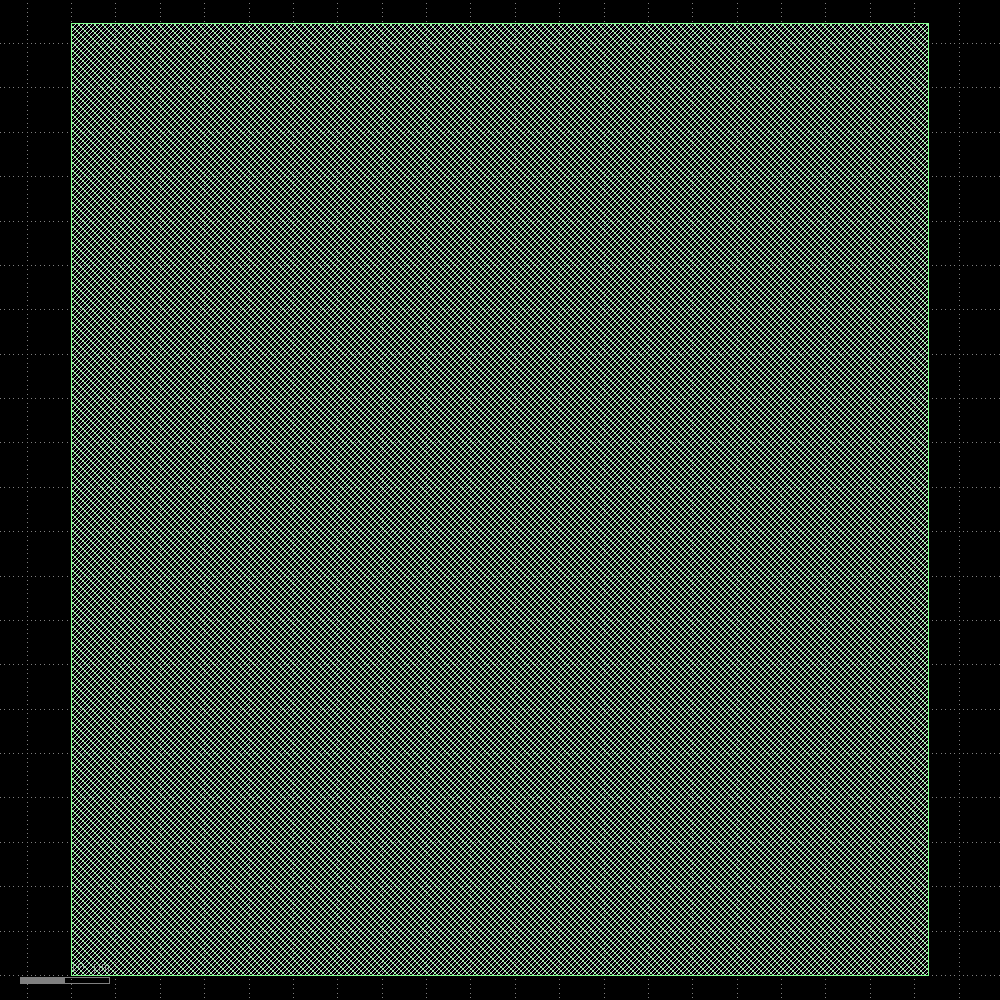

In [12]:
display(floorplan)

In [13]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion()
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

Reading OpenROAD database at '/content/openlane_run/3-openroad-floorplan/spm.odb'…

Reading library file at '/content/openlane_run/tmp/45f5935fabb2422bb08adfae35a086bd.lib'…

Reading design constraints file at '/content/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a2111oi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a21boi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__and2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__buf_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s15_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s18_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__fa_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_bleeder_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_12' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_3' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_6' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputisolatch_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrckapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__mux4_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o21ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o311ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__or2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probe_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probec_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_4' not found.

[INFO TAP-0004] Inserted 62 endcaps.

[INFO TAP-0005] Inserted 99 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/4-openroad-tapendcapinsertion/spm.odb'…

Writing netlist to '/content/openlane_run/4-openroad-tapendcapinsertion/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/4-openroad-tapendcapinsertion/spm.pnl.v'…

Writing layout to '/content/openlane_run/4-openroad-tapendcapinsertion/spm.def'…

Writing timing constraints to '/content/openlane_run/4-openroad-tapendcapinsertion/spm.sdc'…

{'nl': '/content/openlane_run/4-openroad-tapendcapinsertion/spm.nl.v', 'pnl': '/content/openlane_run/4-openroad-tapendcapinsertion/spm.pnl.v', 'def': '/content/openlane_run/4-openroad-tapendcapinsertion/spm.def', 'lef': None, 'odb': '/content/openlane_run/4-openroad-tapendcapinsertion/spm.odb', 'sdc': '/content/openlane_run/4-openroad-tapendcapinsertion/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 386, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 36, 'design__die__area': 10363, 'design__core__area': Decimal('7175.63'), 'design__instance__area': Decimal('3782.38'), 'design__instance__count__stdcell': 386, 'design__instance__area__stdcell': Decimal('3782.38'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.527114'), 'design__instance__utilization__stdcell': Decimal('0.527114')}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 0.91s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
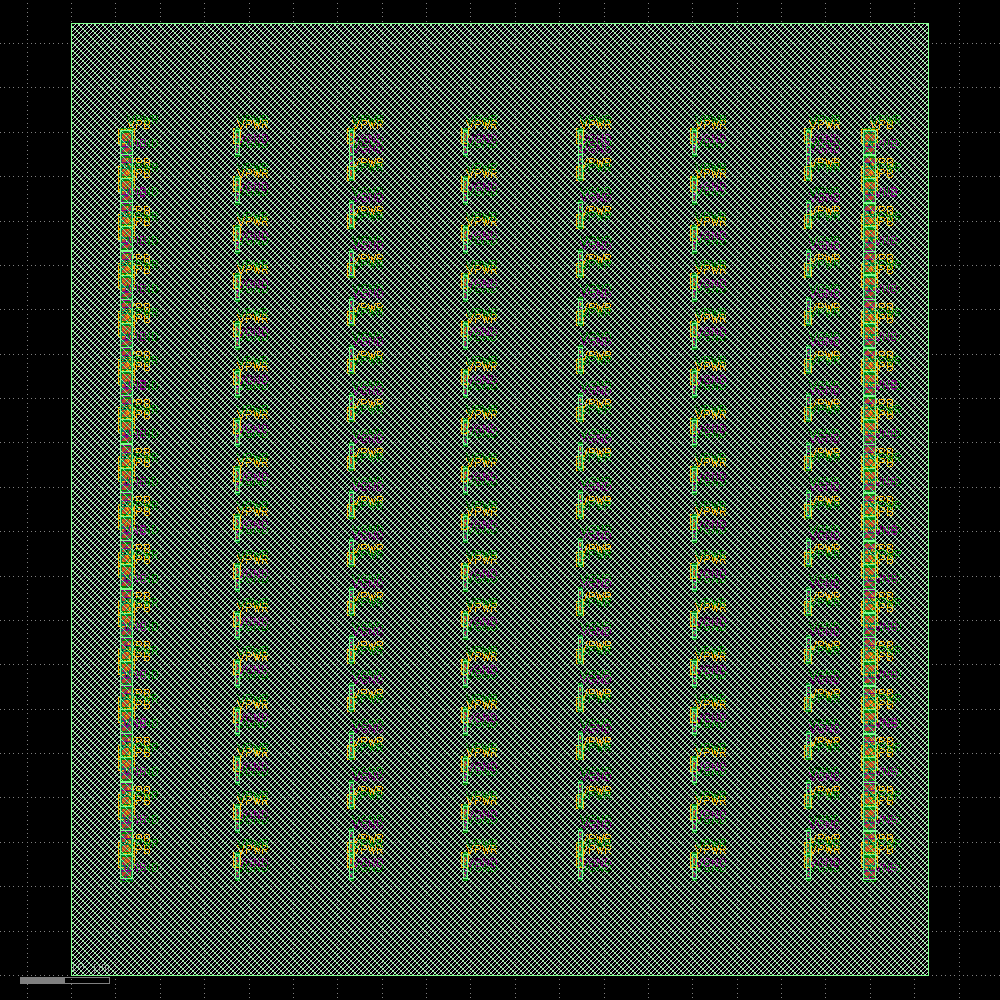

In [14]:
display(tdi)

In [15]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement()
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

Reading OpenROAD database at '/content/openlane_run/4-openroad-tapendcapinsertion/spm.odb'…

Reading library file at '/content/openlane_run/tmp/45f5935fabb2422bb08adfae35a086bd.lib'…

Reading design constraints file at '/content/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a2111oi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a21boi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__and2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__buf_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s15_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s18_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__fa_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_bleeder_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_12' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_3' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_6' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputisolatch_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrckapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__mux4_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o21ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o311ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__or2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probe_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probec_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_4' not found.

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           124

[INFO PPL-0002] Number of I/O             36

[INFO PPL-0003] Number of I/O w/sink      36

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 2622.44 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/5-openroad-ioplacement/spm.odb'…

Writing netlist to '/content/openlane_run/5-openroad-ioplacement/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/5-openroad-ioplacement/spm.pnl.v'…

Writing layout to '/content/openlane_run/5-openroad-ioplacement/spm.def'…

Writing timing constraints to '/content/openlane_run/5-openroad-ioplacement/spm.sdc'…

{'nl': '/content/openlane_run/5-openroad-ioplacement/spm.nl.v', 'pnl': '/content/openlane_run/5-openroad-ioplacement/spm.pnl.v', 'def': '/content/openlane_run/5-openroad-ioplacement/spm.def', 'lef': None, 'odb': '/content/openlane_run/5-openroad-ioplacement/spm.odb', 'sdc': '/content/openlane_run/5-openroad-ioplacement/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 386, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 36, 'design__die__area': 10363, 'design__core__area': Decimal('7175.63'), 'design__instance__area': Decimal('3782.38'), 'design__instance__count__stdcell': 386, 'design__instance__area__stdcell': Decimal('3782.38'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.527114'), 'design__instance__utilization__stdcell': Decimal('0.527114'), 'floorplan__design__io': 36, 'design__io__hpwl': 2622440}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 0.91s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
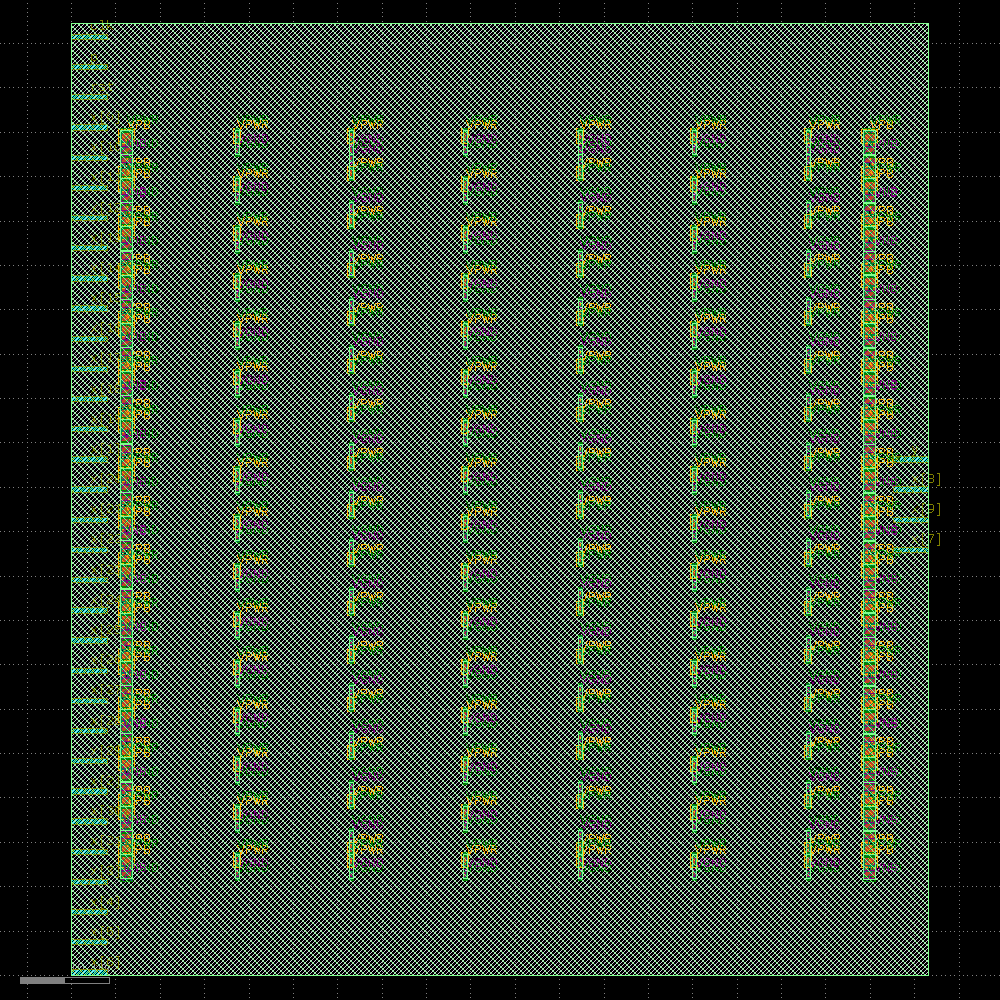

In [16]:
display(ioplace)

In [17]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN()
pdn.start()

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

Reading OpenROAD database at '/content/openlane_run/5-openroad-ioplacement/spm.odb'…

Reading library file at '/content/openlane_run/tmp/45f5935fabb2422bb08adfae35a086bd.lib'…

Reading design constraints file at '/content/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a2111oi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a21boi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__and2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__buf_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s15_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s18_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__fa_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_bleeder_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_12' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_3' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_6' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputisolatch_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrckapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__mux4_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o21ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o311ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__or2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probe_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probec_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_4' not found.

[INFO] Setting global connections...

adding -skip_trim to pdngen

[INFO PDN-0001] Inserting grid: stdcell_grid

[INFO PSM-0076] Setting metal node density to be standard cell height times 5.

[INFO PSM-0031] Number of PDN nodes on net VPWR = 262.

[INFO PSM-0064] Number of voltage sources = 7.

[INFO PSM-0040] All PDN stripes on net VPWR are connected.

[INFO PSM-0076] Setting metal node density to be standard cell height times 5.

[INFO PSM-0031] Number of PDN nodes on net VGND = 246.

[INFO PSM-0064] Number of voltage sources = 7.

[INFO PSM-0040] All PDN stripes on net VGND are connected.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/6-openroad-generatepdn/spm.odb'…

Writing netlist to '/content/openlane_run/6-openroad-generatepdn/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/6-openroad-generatepdn/spm.pnl.v'…

Writing layout to '/content/openlane_run/6-openroad-generatepdn/spm.def'…

Writing timing constraints to '/content/openlane_run/6-openroad-generatepdn/spm.sdc'…

{'nl': '/content/openlane_run/6-openroad-generatepdn/spm.nl.v', 'pnl': '/content/openlane_run/6-openroad-generatepdn/spm.pnl.v', 'def': '/content/openlane_run/6-openroad-generatepdn/spm.def', 'lef': None, 'odb': '/content/openlane_run/6-openroad-generatepdn/spm.odb', 'sdc': '/content/openlane_run/6-openroad-generatepdn/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 386, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': 10363, 'design__core__area': Decimal('7175.63'), 'design__instance__area': Decimal('3782.38'), 'design__instance__count__stdcell': 386, 'design__instance__area__stdcell': Decimal('3782.38'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.527114'), 'design__instance__utilization__stdcell': Decimal('0.527114'), 'floorplan__design__io': 36, 'design__io__hpwl': 2622440}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 0.91s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
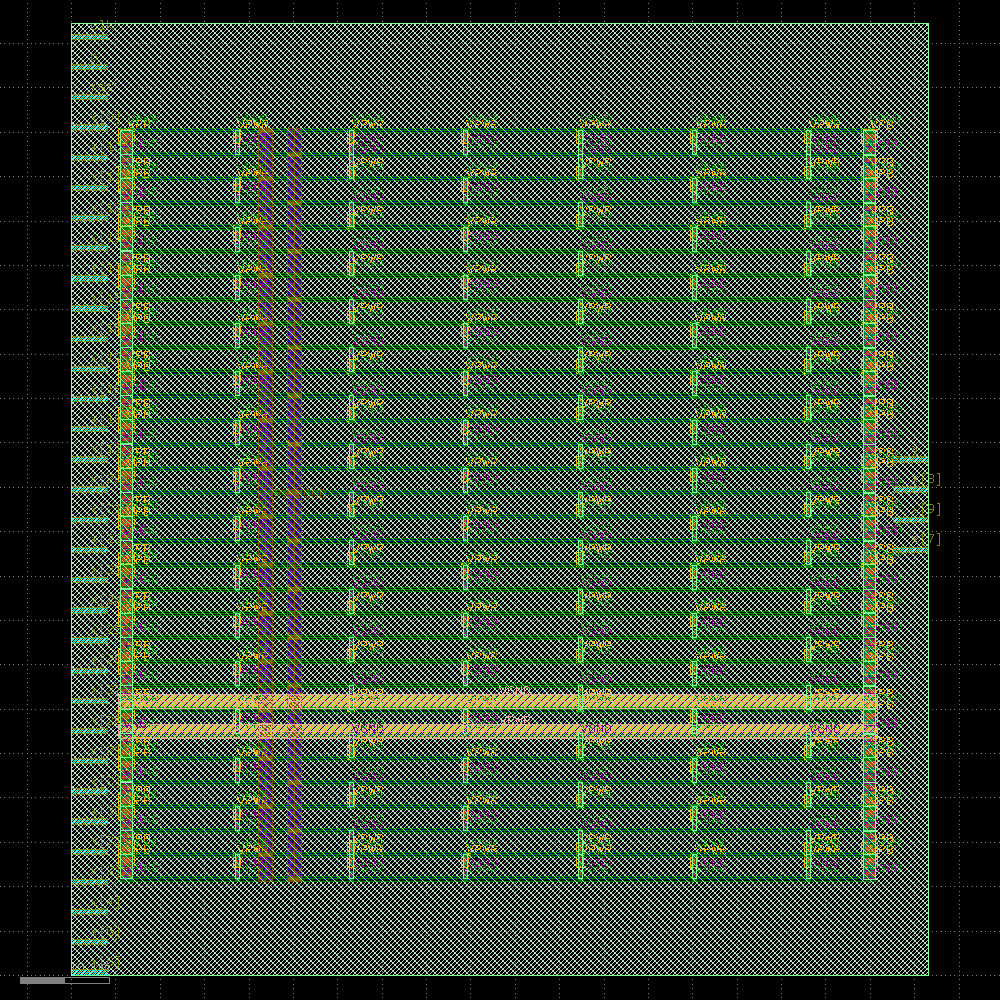

In [18]:
display(pdn)

In [19]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement()
gpl.start()

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

[19:28:04] ⚠️   'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated target      ]8;id=585813;file:///content/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=19577;file:///content/openlane/steps/openroad.py#843\843]8;;\
           density: 60…                                                                                            

WARN:__openlane__:⚠️  [gold][bold] 'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated target density: 60…


Reading OpenROAD database at '/content/openlane_run/6-openroad-generatepdn/spm.odb'…

Reading library file at '/content/openlane_run/tmp/45f5935fabb2422bb08adfae35a086bd.lib'…

Reading design constraints file at '/content/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a2111oi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a21boi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__and2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__buf_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s15_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s18_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__fa_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_bleeder_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_12' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_3' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_6' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputisolatch_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrckapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__mux4_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o21ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o311ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__or2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probe_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probec_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_4' not found.

[INFO] Setting RC values…

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

[INFO GPL-0002] DBU: 1000

[INFO GPL-0003] SiteSize: 460 2720

[INFO GPL-0004] CoreAreaLxLy: 5520 10880

[INFO GPL-0005] CoreAreaUxUy: 90620 95200

[INFO GPL-0006] NumInstances: 448

[INFO GPL-0007] NumPlaceInstances: 287

[INFO GPL-0008] NumFixedInstances: 161

[INFO GPL-0009] NumDummyInstances: 0

[INFO GPL-0010] NumNets: 322

[INFO GPL-0011] NumPins: 960

[INFO GPL-0012] DieAreaLxLy: 0 0

[INFO GPL-0013] DieAreaUxUy: 96580 107300

[INFO GPL-0014] CoreAreaLxLy: 5520 10880

[INFO GPL-0015] CoreAreaUxUy: 90620 95200

[INFO GPL-0016] CoreArea: 7175632000

[INFO GPL-0017] NonPlaceInstsArea: 356592000

[INFO GPL-0018] PlaceInstsArea: 3658508800

[INFO GPL-0019] Util(%): 53.65

[INFO GPL-0020] StdInstsArea: 3658508800

[INFO GPL-0021] MacroInstsArea: 0

[InitialPlace]  Iter: 1 CG residual: 0.00000010 HPWL: 5547960

[InitialPlace]  Iter: 2 CG residual: 0.00000010 HPWL: 4838048

[InitialPlace]  Iter: 3 CG residual: 0.00000011 HPWL: 4606742

[InitialPlace]  Iter: 4 CG residual: 0.00000011 HPWL: 4539823

[InitialPlace]  Iter: 5 CG residual: 0.00000012 HPWL: 4518378

[INFO GPL-0031] FillerInit: NumGCells: 321

[INFO GPL-0032] FillerInit: NumGNets: 322

[INFO GPL-0033] FillerInit: NumGPins: 960

[INFO GPL-0023] TargetDensity: 0.60

[INFO GPL-0024] AveragePlaceInstArea: 12747417

[INFO GPL-0025] IdealBinArea: 21245694

[INFO GPL-0026] IdealBinCnt: 337

[INFO GPL-0027] TotalBinArea: 7175632000

[INFO GPL-0028] BinCnt: 16 16

[INFO GPL-0029] BinSize: 5319 5270

[INFO GPL-0030] NumBins: 256

[NesterovSolve] Iter: 1 overflow: 0.830949 HPWL: 2054404

[NesterovSolve] Iter: 10 overflow: 0.794473 HPWL: 2155118

[INFO GPL-0100] worst slack 6.83e-09

[INFO GPL-0103] Weighted 32 nets.

[NesterovSolve] Iter: 20 overflow: 0.771011 HPWL: 2161423

[NesterovSolve] Iter: 30 overflow: 0.777134 HPWL: 2191365

[NesterovSolve] Iter: 40 overflow: 0.783565 HPWL: 2179628

[NesterovSolve] Iter: 50 overflow: 0.780673 HPWL: 2172518

[NesterovSolve] Iter: 60 overflow: 0.777811 HPWL: 2176003

[NesterovSolve] Iter: 70 overflow: 0.779062 HPWL: 2178869

[NesterovSolve] Iter: 80 overflow: 0.779771 HPWL: 2176856

[NesterovSolve] Iter: 90 overflow: 0.778144 HPWL: 2174627

[NesterovSolve] Iter: 100 overflow: 0.776564 HPWL: 2174412

[NesterovSolve] Iter: 110 overflow: 0.775541 HPWL: 2173530

[NesterovSolve] Iter: 120 overflow: 0.773375 HPWL: 2171587

[NesterovSolve] Iter: 130 overflow: 0.76908 HPWL: 2171021

[NesterovSolve] Iter: 140 overflow: 0.762277 HPWL: 2170943

[NesterovSolve] Iter: 150 overflow: 0.749875 HPWL: 2169028

[NesterovSolve] Iter: 160 overflow: 0.73956 HPWL: 2167874

[NesterovSolve] Iter: 170 overflow: 0.729135 HPWL: 2184485

[NesterovSolve] Iter: 180 overflow: 0.705706 HPWL: 2236621

[NesterovSolve] Iter: 190 overflow: 0.681932 HPWL: 2312544

[NesterovSolve] Iter: 200 overflow: 0.634111 HPWL: 2416883

[INFO GPL-0100] worst slack 6.83e-09

[INFO GPL-0103] Weighted 32 nets.

[NesterovSolve] Snapshot saved at iter = 208

[NesterovSolve] Iter: 210 overflow: 0.591318 HPWL: 2473620

[NesterovSolve] Iter: 220 overflow: 0.54373 HPWL: 2540514

[NesterovSolve] Iter: 230 overflow: 0.484028 HPWL: 2611793

[INFO GPL-0100] worst slack 6.51e-09

[INFO GPL-0103] Weighted 32 nets.

[NesterovSolve] Iter: 240 overflow: 0.417647 HPWL: 2659618

[NesterovSolve] Iter: 250 overflow: 0.370793 HPWL: 2705604

[NesterovSolve] Iter: 260 overflow: 0.347457 HPWL: 2782254

[NesterovSolve] Iter: 270 overflow: 0.336145 HPWL: 2801610

[NesterovSolve] Iter: 280 overflow: 0.313936 HPWL: 2796166

[NesterovSolve] Iter: 290 overflow: 0.297996 HPWL: 2831747

[INFO GPL-0100] worst slack 6.92e-09

[INFO GPL-0103] Weighted 31 nets.

[NesterovSolve] Iter: 300 overflow: 0.279087 HPWL: 2852077

[NesterovSolve] Iter: 310 overflow: 0.259497 HPWL: 2883152

[NesterovSolve] Iter: 320 overflow: 0.239501 HPWL: 2907530

[NesterovSolve] Iter: 330 overflow: 0.212645 HPWL: 2938564

[INFO GPL-0100] worst slack 6.9e-09

[INFO GPL-0103] Weighted 32 nets.

[INFO GPL-0075] Routability numCall: 1 inflationIterCnt: 1 bloatIterCnt: 0

[INFO GPL-0036] TileLxLy: 0 0

[INFO GPL-0037] TileSize: 6900 6900

[INFO GPL-0038] TileCnt: 13 15

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 195

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1

[INFO GPL-0067] 1.0%RC: 0.9749999940395355

[INFO GPL-0068] 2.0%RC: 0.9291666597127914

[INFO GPL-0069] 5.0%RC: 0.8821428673607963

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 0.9875

[NesterovSolve] Iter: 340 overflow: 0.189505 HPWL: 2978245

[NesterovSolve] Iter: 350 overflow: 0.167464 HPWL: 3001019

[INFO GPL-0100] worst slack 6.91e-09

[INFO GPL-0103] Weighted 32 nets.

[NesterovSolve] Iter: 360 overflow: 0.13894 HPWL: 3032781

[NesterovSolve] Iter: 370 overflow: 0.118994 HPWL: 3069599

[NesterovSolve] Finished with Overflow: 0.099126

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/7-openroad-globalplacement/spm.odb'…

Writing netlist to '/content/openlane_run/7-openroad-globalplacement/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/7-openroad-globalplacement/spm.pnl.v'…

Writing layout to '/content/openlane_run/7-openroad-globalplacement/spm.def'…

Writing timing constraints to '/content/openlane_run/7-openroad-globalplacement/spm.sdc'…

{'nl': '/content/openlane_run/7-openroad-globalplacement/spm.nl.v', 'pnl': '/content/openlane_run/7-openroad-globalplacement/spm.pnl.v', 'def': '/content/openlane_run/7-openroad-globalplacement/spm.def', 'lef': None, 'odb': '/content/openlane_run/7-openroad-globalplacement/spm.odb', 'sdc': '/content/openlane_run/7-openroad-globalplacement/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 386, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': 10363, 'design__core__area': Decimal('7175.63'), 'design__instance__area': Decimal('3782.38'), 'design__instance__count__stdcell': 386, 'design__instance__area__stdcell': Decimal('3782.38'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.527114'), 'design__instance__utilization__stdcell': Decimal('0.527114'), 'floorplan__design__io': 36, 'design__io__hpwl': 2622440}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 2.34s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
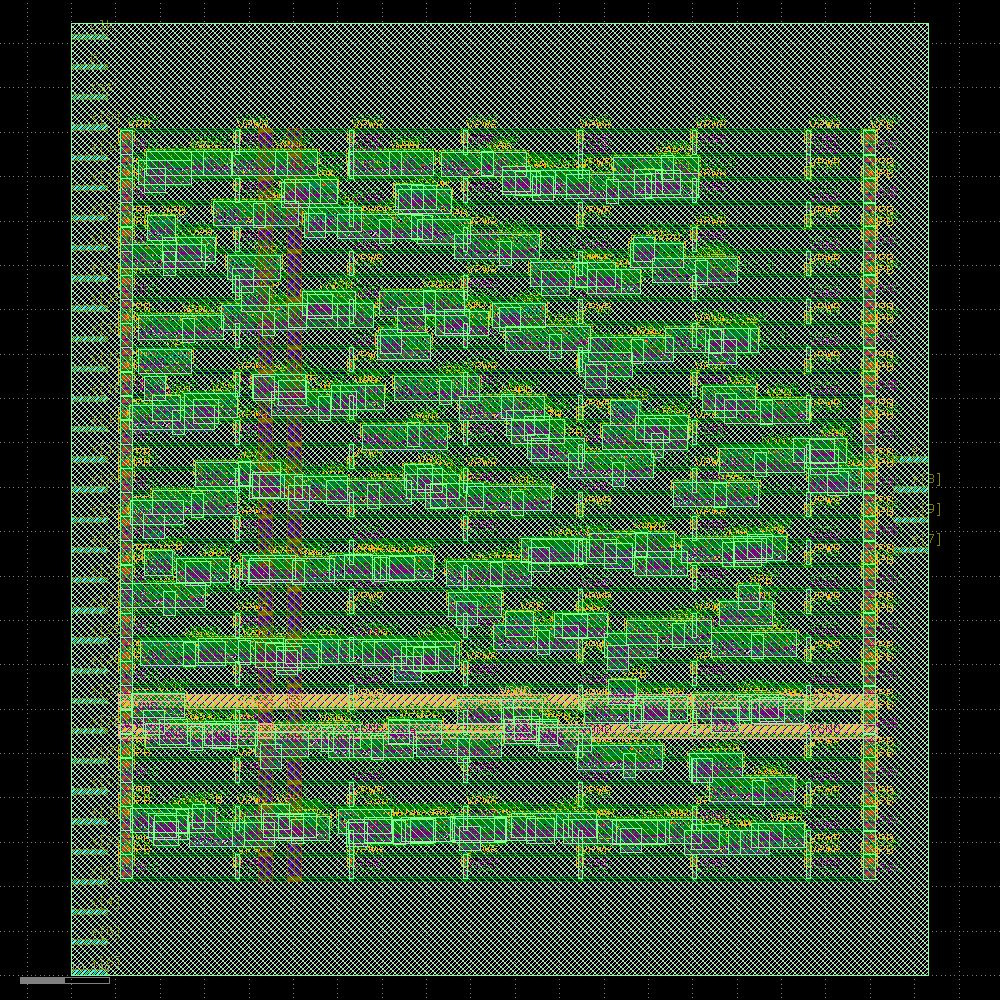

In [20]:
display(gpl)

In [21]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement()
dpl.start()

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

Reading OpenROAD database at '/content/openlane_run/7-openroad-globalplacement/spm.odb'…

Reading library file at '/content/openlane_run/tmp/45f5935fabb2422bb08adfae35a086bd.lib'…

Reading design constraints file at '/content/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a2111oi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a21boi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__and2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__buf_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s15_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s18_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__fa_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_bleeder_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_12' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_3' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_6' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputisolatch_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrckapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__mux4_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o21ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o311ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__or2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probe_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probec_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_4' not found.

Placement Analysis

---------------------------------

total displacement        740.1 u

average displacement        1.7 u

max displacement            8.3 u

original HPWL            3124.0 u

legalized HPWL           4006.1 u

delta HPWL                   28 %

[INFO DPL-0020] Mirrored 89 instances

[INFO DPL-0021] HPWL before            4006.1 u

[INFO DPL-0022] HPWL after             3789.0 u

[INFO DPL-0023] HPWL delta               -5.4 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/8-openroad-detailedplacement/spm.odb'…

Writing netlist to '/content/openlane_run/8-openroad-detailedplacement/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/8-openroad-detailedplacement/spm.pnl.v'…

Writing layout to '/content/openlane_run/8-openroad-detailedplacement/spm.def'…

Writing timing constraints to '/content/openlane_run/8-openroad-detailedplacement/spm.sdc'…

{'nl': '/content/openlane_run/8-openroad-detailedplacement/spm.nl.v', 'pnl': '/content/openlane_run/8-openroad-detailedplacement/spm.pnl.v', 'def': '/content/openlane_run/8-openroad-detailedplacement/spm.def', 'lef': None, 'odb': '/content/openlane_run/8-openroad-detailedplacement/spm.odb', 'sdc': '/content/openlane_run/8-openroad-detailedplacement/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 386, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': 10363, 'design__core__area': Decimal('7175.63'), 'design__instance__area': Decimal('3782.38'), 'design__instance__count__stdcell': 386, 'design__instance__area__stdcell': Decimal('3782.38'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.527114'), 'design__instance__utilization__stdcell': Decimal('0.527114'), 'floorplan__design__io': 36, 'design__io__hpwl': 2622440, 'design__instance__displacement__total': Decimal('740.106'), 'design__instance__displacement__mean': Decimal('1.652'), 'design__instance__displacement__max': Decimal('8.3'), 'route__wirelength__estimated': Decimal('4006.07'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 1.02s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
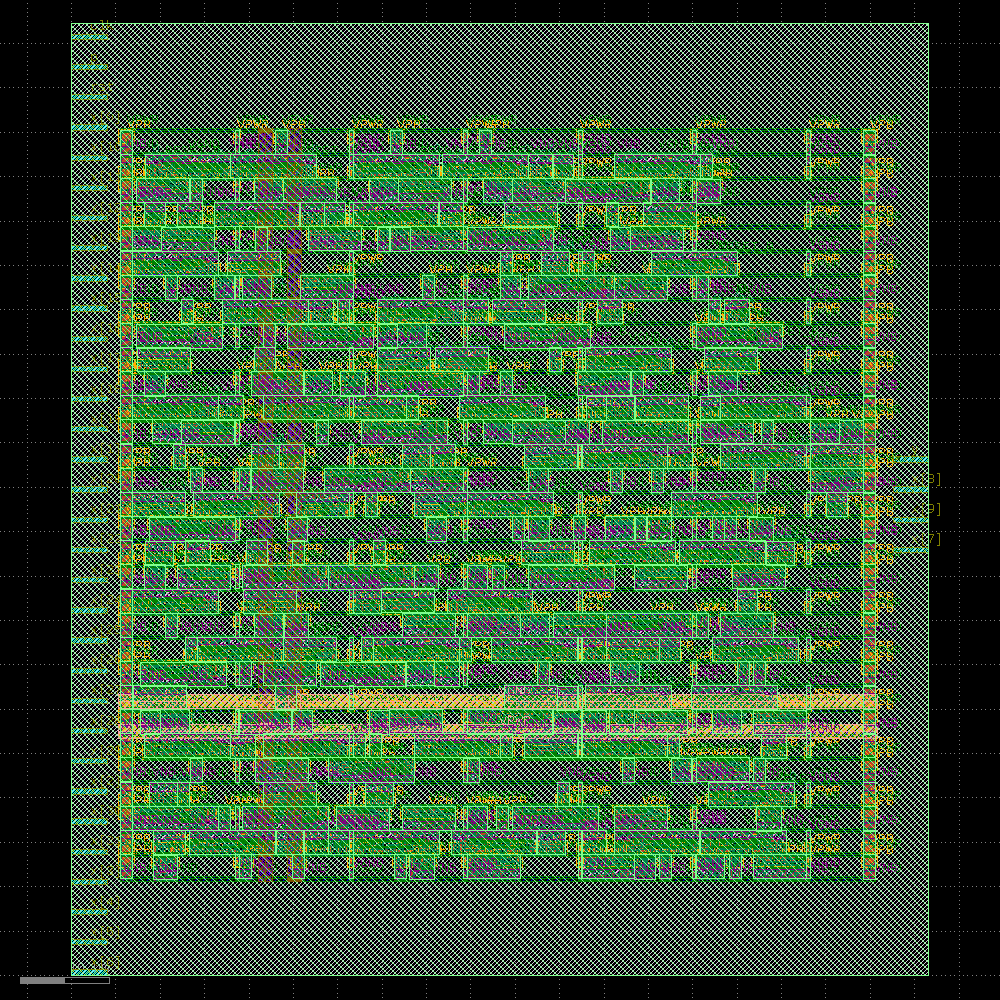

In [22]:
display(dpl)

In [23]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS()
cts.start()

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

Reading timing models for corner nom_tt_025C_1v80…

Reading timing library for the 'nom_tt_025C_1v80' corner at 
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading timing models for corner nom_ff_n40C_1v95…

Reading timing library for the 'nom_ff_n40C_1v95' corner at 
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib'…

[WARNING STA-0122] message limit reached, this message will no longer print

Reading timing models for corner nom_ss_100C_1v60…

Reading timing library for the 'nom_ss_100C_1v60' corner at 
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib'…

Reading OpenROAD database at '/content/openlane_run/8-openroad-detailedplacement/spm.odb'…

Reading design constraints file at '/content/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Configuring cts characterization…

[INFO] Performing clock tree synthesis…

[INFO] Looking for the following net(s): clk

[INFO] Running Clock Tree Synthesis…

[INFO CTS-0049] Characterization buffer is: sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0038] Number of created patterns = 50000.

[INFO CTS-0038] Number of created patterns = 100000.

[INFO CTS-0039] Number of created patterns = 141984.

[INFO CTS-0084] Compiling LUT.

Min. len    Max. len    Min. cap    Max. cap    Min. slew   Max. slew

2           8           1           34          1           12

[WARNING CTS-0043] 4896 wires are pure wire and no slew degradation.

TritonCTS forced slew degradation on these wires.

[INFO CTS-0046]     Number of wire segments: 141984.

[INFO CTS-0047]     Number of keys in characterization LUT: 1656.

[INFO CTS-0048]     Actual min input cap: 1.

[INFO CTS-0007] Net "clk" found for clock "clk".

[INFO CTS-0010]  Clock net "clk" has 64 sinks.

[INFO CTS-0008] TritonCTS found 1 clock nets.

[INFO CTS-0097] Characterization used 2 buffer(s) types.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net clk.

[INFO CTS-0028]  Total number of sinks: 64.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0023]  Original sink region: [(7165, 15020), (73405, 91180)].

[INFO CTS-0024]  Normalized sink region: [(0.526838, 1.10441), (5.39743, 6.70441)].

[INFO CTS-0025]     Width:  4.8706.

[INFO CTS-0026]     Height: 5.6000.

[WARNING CTS-0045] Creating fake entries in the LUT.

Level 1

Direction: Vertical

Sinks per sub-region: 32

Sub-region size: 4.8706 X 2.8000

[INFO CTS-0034]     Segment length (rounded): 1.

Key: 142164 inSlew: 1 inCap: 1 outSlew: 2 load: 1 length: 1 delay: 1

Level 2

Direction: Horizontal

Sinks per sub-region: 16

Sub-region size: 2.4353 X 2.8000

[INFO CTS-0034]     Segment length (rounded): 1.

Key: 142164 inSlew: 1 inCap: 1 outSlew: 2 load: 1 length: 1 delay: 1

Level 3

Direction: Vertical

Sinks per sub-region: 8

Sub-region size: 2.4353 X 1.4000

[INFO CTS-0034]     Segment length (rounded): 1.

Key: 142167 inSlew: 2 inCap: 1 outSlew: 3 load: 1 length: 1 delay: 1

Out of 16 sinks, 1 sinks closer to other cluster.

Out of 18 sinks, 1 sinks closer to other cluster.

Out of 15 sinks, 1 sinks closer to other cluster.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 64.

[INFO CTS-0018]     Created 9 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 2.

[INFO CTS-0015]     Created 9 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 6:1, 7:1, 8:4, 9:1, 10:1..

[INFO CTS-0017]     Max level of the clock tree: 3.

[INFO CTS-0098] Clock net "clk"

[INFO CTS-0099]  Sinks 64

[INFO CTS-0100]  Leaf buffers 0

[INFO CTS-0101]  Average sink wire length 142.92 um

[INFO CTS-0102]  Path depth 2 - 2

[INFO] Repairing long wires on clock nets…

[INFO RSZ-0058] Using max wire length 4459um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/9-openroad-cts/spm.odb'…

Writing netlist to '/content/openlane_run/9-openroad-cts/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/9-openroad-cts/spm.pnl.v'…

Writing layout to '/content/openlane_run/9-openroad-cts/spm.def'…

Writing timing constraints to '/content/openlane_run/9-openroad-cts/spm.sdc'…

[INFO] Legalizing…

Placement Analysis

---------------------------------

total displacement        113.4 u

average displacement        0.2 u

max displacement            8.3 u

original HPWL            4160.0 u

legalized HPWL           4530.5 u

delta HPWL                    9 %

[INFO DPL-0020] Mirrored 95 instances

[INFO DPL-0021] HPWL before            4530.5 u

[INFO DPL-0022] HPWL after             4295.1 u

[INFO DPL-0023] HPWL delta               -5.2 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/9-openroad-cts/spm.odb'…

Writing netlist to '/content/openlane_run/9-openroad-cts/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/9-openroad-cts/spm.pnl.v'…

Writing layout to '/content/openlane_run/9-openroad-cts/spm.def'…

Writing timing constraints to '/content/openlane_run/9-openroad-cts/spm.sdc'…

{'nl': '/content/openlane_run/9-openroad-cts/spm.nl.v', 'pnl': '/content/openlane_run/9-openroad-cts/spm.pnl.v', 'def': '/content/openlane_run/9-openroad-cts/spm.def', 'lef': None, 'odb': '/content/openlane_run/9-openroad-cts/spm.odb', 'sdc': '/content/openlane_run/9-openroad-cts/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 395, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': 10363, 'design__core__area': Decimal('7175.63'), 'design__instance__area': Decimal('4007.59'), 'design__instance__count__stdcell': 395, 'design__instance__area__stdcell': Decimal('4007.59'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.5585'), 'design__instance__utilization__stdcell': Decimal('0.5585'), 'floorplan__design__io': 36, 'design__io__hpwl': 2622440, 'design__instance__displacement__total': Decimal('113.401'), 'design__instance__displacement__mean': Decimal('0.248'), 'design__instance__displacement__max': Decimal('8.28'), 'route__wirelength__estimated': Decimal('4530.47'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 68.21s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
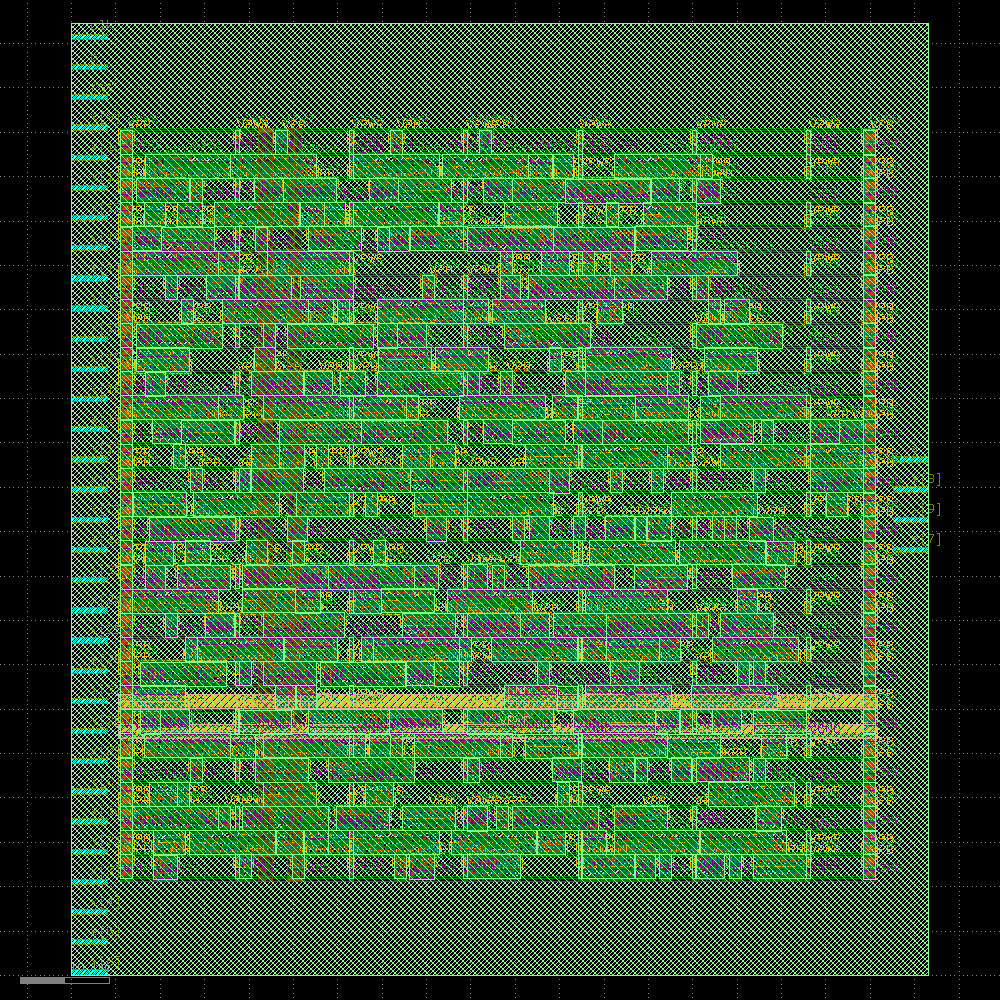

In [24]:
display(cts)

In [25]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting()
grt.start()

───────────────────────────────────────────────── Global Routing ──────────────────────────────────────────────────

Reading OpenROAD database at '/content/openlane_run/9-openroad-cts/spm.odb'…

Reading library file at '/content/openlane_run/tmp/45f5935fabb2422bb08adfae35a086bd.lib'…

Reading design constraints file at '/content/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a2111oi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a21boi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__and2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__buf_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s15_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s18_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__fa_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_bleeder_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_12' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_3' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_6' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputisolatch_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrckapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__mux4_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o21ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o311ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__or2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probe_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probec_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_4' not found.

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

-congestion_iterations 50 -verbose

[INFO GRT-0020] Min routing layer: met1

[INFO GRT-0021] Max routing layer: met5

[INFO GRT-0022] Global adjustment: 30%

[INFO GRT-0023] Grid origin: (0, 0)

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0088] Layer li1     Track-Pitch = 0.4600  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met1    Track-Pitch = 0.3400  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met2    Track-Pitch = 0.4600  line-2-Via Pitch: 0.3500

[INFO GRT-0088] Layer met3    Track-Pitch = 0.6800  line-2-Via Pitch: 0.6150

[INFO GRT-0088] Layer met4    Track-Pitch = 0.9200  line-2-Via Pitch: 1.0400

[INFO GRT-0088] Layer met5    Track-Pitch = 3.4000  line-2-Via Pitch: 3.1100

[INFO GRT-0019] Found 10 clock nets.

[INFO GRT-0001] Minimum degree: 2

[INFO GRT-0002] Maximum degree: 65

[INFO GRT-0003] Macros: 0

[INFO GRT-0004] Blockages: 1206

[INFO GRT-0053] Routing resources analysis:

Routing      Original      Derated      Resource

Layer     Direction    Resources     Resources    Reduction (%)

---------------------------------------------------------------

li1        Vertical            0             0          0.00%

met1       Horizontal       4003          1876          53.14%

met2       Vertical         3165          1957          38.17%

met3       Horizontal       1995          1240          37.84%

met4       Vertical         1302           762          41.47%

met5       Horizontal        399           180          54.89%

---------------------------------------------------------------

[INFO GRT-0197] Via related to pin nodes: 1167

[INFO GRT-0198] Via related Steiner nodes: 18

[INFO GRT-0199] Via filling finished.

[INFO GRT-0111] Final number of vias: 1261

[INFO GRT-0112] Final usage 3D: 4482

[INFO GRT-0096] Final congestion report:

Layer         Resource        Demand        Usage (%)    Max H / Max V / Total Overflow

---------------------------------------------------------------------------------------

li1                  0             0            0.00%             0 /  0 /  0

met1              1876           358           19.08%             0 /  0 /  0

met2              1957           341           17.42%             0 /  0 /  0

met3              1240             0            0.00%             0 /  0 /  0

met4               762             0            0.00%             0 /  0 /  0

met5               180             0            0.00%             0 /  0 /  0

---------------------------------------------------------------------------------------

Total             6015           699           11.62%             0 /  0 /  0

[INFO GRT-0018] Total wirelength: 9846 um

[INFO GRT-0014] Routed nets: 331

[INFO GRT-0006] Repairing antennas, iteration 1.

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0012] Found 0 antenna violations.

Placement Analysis

---------------------------------

total displacement          0.0 u

average displacement        0.0 u

max displacement            0.0 u

original HPWL            4295.1 u

legalized HPWL           4530.5 u

delta HPWL                    5 %

[INFO DPL-0020] Mirrored 95 instances

[INFO DPL-0021] HPWL before            4530.5 u

[INFO DPL-0022] HPWL after             4295.1 u

[INFO DPL-0023] HPWL delta               -5.2 %

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

-congestion_iterations 50 -verbose

[INFO GRT-0020] Min routing layer: met1

[INFO GRT-0021] Max routing layer: met5

[INFO GRT-0022] Global adjustment: 30%

[INFO GRT-0023] Grid origin: (0, 0)

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0088] Layer li1     Track-Pitch = 0.4600  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met1    Track-Pitch = 0.3400  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met2    Track-Pitch = 0.4600  line-2-Via Pitch: 0.3500

[INFO GRT-0088] Layer met3    Track-Pitch = 0.6800  line-2-Via Pitch: 0.6150

[INFO GRT-0088] Layer met4    Track-Pitch = 0.9200  line-2-Via Pitch: 1.0400

[INFO GRT-0088] Layer met5    Track-Pitch = 3.4000  line-2-Via Pitch: 3.1100

[INFO GRT-0019] Found 10 clock nets.

[INFO GRT-0001] Minimum degree: 2

[INFO GRT-0002] Maximum degree: 65

[INFO GRT-0003] Macros: 0

[INFO GRT-0004] Blockages: 1206

[INFO GRT-0053] Routing resources analysis:

Routing      Original      Derated      Resource

Layer     Direction    Resources     Resources    Reduction (%)

---------------------------------------------------------------

li1        Vertical            0             0          0.00%

met1       Horizontal       4003          1876          53.14%

met2       Vertical         3165          1957          38.17%

met3       Horizontal       1995          1240          37.84%

met4       Vertical         1302           762          41.47%

met5       Horizontal        399           180          54.89%

---------------------------------------------------------------

[INFO GRT-0197] Via related to pin nodes: 1167

[INFO GRT-0198] Via related Steiner nodes: 18

[INFO GRT-0199] Via filling finished.

[INFO GRT-0111] Final number of vias: 1261

[INFO GRT-0112] Final usage 3D: 4482

[INFO GRT-0096] Final congestion report:

Layer         Resource        Demand        Usage (%)    Max H / Max V / Total Overflow

---------------------------------------------------------------------------------------

li1                  0             0            0.00%             0 /  0 /  0

met1              1876           358           19.08%             0 /  0 /  0

met2              1957           341           17.42%             0 /  0 /  0

met3              1240             0            0.00%             0 /  0 /  0

met4               762             0            0.00%             0 /  0 /  0

met5               180             0            0.00%             0 /  0 /  0

---------------------------------------------------------------------------------------

Total             6015           699           11.62%             0 /  0 /  0

[INFO GRT-0018] Total wirelength: 9846 um

[INFO GRT-0014] Routed nets: 331

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/10-openroad-globalrouting/spm.odb'…

Writing netlist to '/content/openlane_run/10-openroad-globalrouting/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/10-openroad-globalrouting/spm.pnl.v'…

Writing layout to '/content/openlane_run/10-openroad-globalrouting/spm.def'…

Writing timing constraints to '/content/openlane_run/10-openroad-globalrouting/spm.sdc'…

{'nl': '/content/openlane_run/10-openroad-globalrouting/spm.nl.v', 'pnl': '/content/openlane_run/10-openroad-globalrouting/spm.pnl.v', 'def': '/content/openlane_run/10-openroad-globalrouting/spm.def', 'lef': None, 'odb': '/content/openlane_run/10-openroad-globalrouting/spm.odb', 'sdc': '/content/openlane_run/10-openroad-globalrouting/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 395, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': 10363, 'design__core__area': Decimal('7175.63'), 'design__instance__area': Decimal('4007.59'), 'design__instance__count__stdcell': 395, 'design__instance__area__stdcell': Decimal('4007.59'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.5585'), 'design__instance__utilization__stdcell': Decimal('0.5585'), 'floorplan__design__io': 36, 'design__io__hpwl': 2622440, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wirelength__estimated': Decimal('4530.47'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'antenna__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 1.83s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
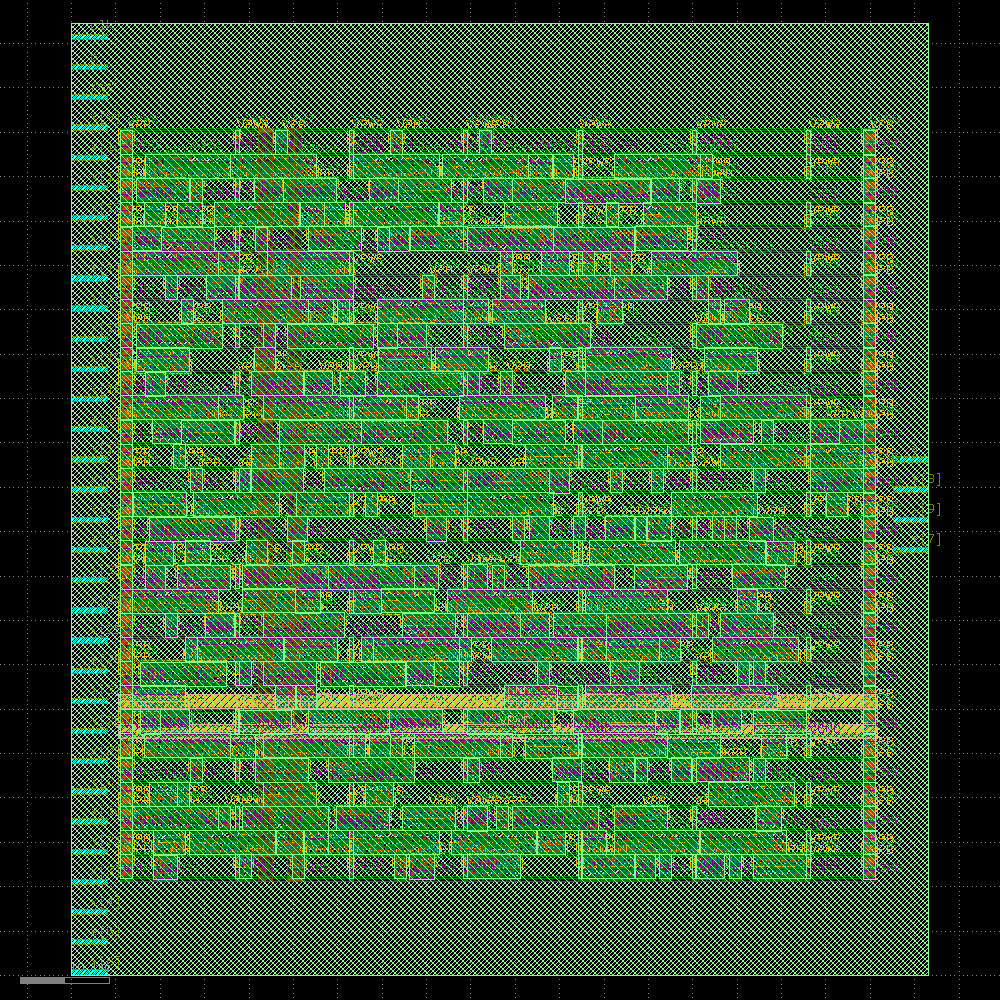

In [26]:
display(grt)

In [27]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting()
drt.start()

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

[19:30:49] ⚠️   DRT_THREADS is not set. Setting it to 2…                                            ]8;id=371541;file:///content/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=87020;file:///content/openlane/steps/openroad.py#1037\1037]8;;\

WARN:__openlane__:⚠️  [gold][bold] DRT_THREADS is not set. Setting it to 2…


Reading OpenROAD database at '/content/openlane_run/10-openroad-globalrouting/spm.odb'…

Reading library file at '/content/openlane_run/tmp/45f5935fabb2422bb08adfae35a086bd.lib'…

Reading design constraints file at '/content/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a2111oi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a21boi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__and2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__buf_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s15_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s18_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__fa_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_bleeder_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_12' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_3' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_6' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputisolatch_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrckapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__mux4_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o21ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o311ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__or2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probe_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probec_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_4' not found.

[INFO ORD-0030] Using 2 thread(s).

[INFO DRT-0149] Reading tech and libs.

Units:                1000

Number of layers:     13

Number of macros:     442

Number of vias:       25

Number of viarulegen: 25

[INFO DRT-0150] Reading design.

Design:                   spm

Die area:                 ( 0 0 ) ( 96580 107300 )

Number of track patterns: 12

Number of DEF vias:       0

Number of components:     457

Number of terminals:      38

Number of snets:          2

Number of nets:           331

[INFO DRT-0167] List of default vias:

Layer via

default via: M1M2_PR

Layer via2

default via: M2M3_PR

Layer via3

default via: M3M4_PR

Layer via4

default via: M4M5_PR

[INFO DRT-0162] Library cell analysis.

[INFO DRT-0163] Instance analysis.

[INFO DRT-0164] Number of unique instances = 39.

[INFO DRT-0168] Init region query.

[INFO DRT-0024]   Complete FR_MASTERSLICE.

[INFO DRT-0024]   Complete Fr_VIA.

[INFO DRT-0024]   Complete li1.

[INFO DRT-0024]   Complete mcon.

[INFO DRT-0024]   Complete met1.

[INFO DRT-0024]   Complete via.

[INFO DRT-0024]   Complete met2.

[INFO DRT-0024]   Complete via2.

[INFO DRT-0024]   Complete met3.

[INFO DRT-0024]   Complete via3.

[INFO DRT-0024]   Complete met4.

[INFO DRT-0024]   Complete via4.

[INFO DRT-0024]   Complete met5.

[INFO DRT-0033] FR_MASTERSLICE shape region query size = 0.

[INFO DRT-0033] FR_VIA shape region query size = 0.

[INFO DRT-0033] li1 shape region query size = 12323.

[INFO DRT-0033] mcon shape region query size = 7478.

[INFO DRT-0033] met1 shape region query size = 2215.

[INFO DRT-0033] via shape region query size = 160.

[INFO DRT-0033] met2 shape region query size = 96.

[INFO DRT-0033] via2 shape region query size = 128.

[INFO DRT-0033] met3 shape region query size = 132.

[INFO DRT-0033] via3 shape region query size = 128.

[INFO DRT-0033] met4 shape region query size = 38.

[INFO DRT-0033] via4 shape region query size = 2.

[INFO DRT-0033] met5 shape region query size = 6.

[INFO DRT-0165] Start pin access.

[INFO DRT-0076]   Complete 100 pins.

[INFO DRT-0078]   Complete 103 pins.

[INFO DRT-0081]   Complete 33 unique inst patterns.

[INFO DRT-0084]   Complete 217 groups.

#scanned instances     = 457

#unique  instances     = 39

#stdCellGenAp          = 1020

#stdCellValidPlanarAp  = 44

#stdCellValidViaAp     = 689

#stdCellPinNoAp        = 0

#stdCellPinCnt         = 942

#instTermValidViaApCnt = 0

#macroGenAp            = 0

#macroValidPlanarAp    = 0

#macroValidViaAp       = 0

#macroNoAp             = 0

[INFO DRT-0166] Complete pin access.

[INFO DRT-0267] cpu time = 00:00:10, elapsed time = 00:00:09, memory = 114.13 (MB), peak = 116.84 (MB)

Number of guides:     2060

[INFO DRT-0169] Post process guides.

[INFO DRT-0176] GCELLGRID X 0 DO 13 STEP 6900 ;

[INFO DRT-0177] GCELLGRID Y 0 DO 15 STEP 6900 ;

[INFO DRT-0028]   Complete FR_MASTERSLICE.

[INFO DRT-0028]   Complete Fr_VIA.

[INFO DRT-0028]   Complete li1.

[INFO DRT-0028]   Complete mcon.

[INFO DRT-0028]   Complete met1.

[INFO DRT-0028]   Complete via.

[INFO DRT-0028]   Complete met2.

[INFO DRT-0028]   Complete via2.

[INFO DRT-0028]   Complete met3.

[INFO DRT-0028]   Complete via3.

[INFO DRT-0028]   Complete met4.

[INFO DRT-0028]   Complete via4.

[INFO DRT-0028]   Complete met5.

[INFO DRT-0178] Init guide query.

[INFO DRT-0035]   Complete FR_MASTERSLICE (guide).

[INFO DRT-0035]   Complete Fr_VIA (guide).

[INFO DRT-0035]   Complete li1 (guide).

[INFO DRT-0035]   Complete mcon (guide).

[INFO DRT-0035]   Complete met1 (guide).

[INFO DRT-0035]   Complete via (guide).

[INFO DRT-0035]   Complete met2 (guide).

[INFO DRT-0035]   Complete via2 (guide).

[INFO DRT-0035]   Complete met3 (guide).

[INFO DRT-0035]   Complete via3 (guide).

[INFO DRT-0035]   Complete met4 (guide).

[INFO DRT-0035]   Complete via4 (guide).

[INFO DRT-0035]   Complete met5 (guide).

[INFO DRT-0036] FR_MASTERSLICE guide region query size = 0.

[INFO DRT-0036] FR_VIA guide region query size = 0.

[INFO DRT-0036] li1 guide region query size = 662.

[INFO DRT-0036] mcon guide region query size = 0.

[INFO DRT-0036] met1 guide region query size = 556.

[INFO DRT-0036] via guide region query size = 0.

[INFO DRT-0036] met2 guide region query size = 292.

[INFO DRT-0036] via2 guide region query size = 0.

[INFO DRT-0036] met3 guide region query size = 36.

[INFO DRT-0036] via3 guide region query size = 0.

[INFO DRT-0036] met4 guide region query size = 0.

[INFO DRT-0036] via4 guide region query size = 0.

[INFO DRT-0036] met5 guide region query size = 0.

[INFO DRT-0179] Init gr pin query.

[INFO DRT-0245] skipped writing guide updates to database.

[INFO DRT-0185] Post process initialize RPin region query.

[INFO DRT-0181] Start track assignment.

[INFO DRT-0184] Done with 954 vertical wires in 1 frboxes and 592 horizontal wires in 1 frboxes.

[INFO DRT-0186] Done with 48 vertical wires in 1 frboxes and 117 horizontal wires in 1 frboxes.

[INFO DRT-0182] Complete track assignment.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 118.19 (MB), peak = 118.19 (MB)

[INFO DRT-0187] Start routing data preparation.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 118.19 (MB), peak = 118.19 (MB)

[INFO DRT-0194] Start detail routing.

[INFO DRT-0195] Start 0th optimization iteration.

Completing 10% with 0 violations.

elapsed time = 00:00:00, memory = 124.93 (MB).

Completing 20% with 0 violations.

elapsed time = 00:00:01, memory = 128.09 (MB).

Completing 30% with 12 violations.

elapsed time = 00:00:02, memory = 140.70 (MB).

Completing 40% with 18 violations.

elapsed time = 00:00:02, memory = 140.70 (MB).

Completing 50% with 18 violations.

elapsed time = 00:00:03, memory = 144.82 (MB).

Completing 60% with 29 violations.

elapsed time = 00:00:05, memory = 147.91 (MB).

[INFO DRT-0199]   Number of violations = 127.

Viol/Layer         li1   met1   met2

Metal Spacing        2     23      1

Recheck              0     55     21

Short                0     25      0

[INFO DRT-0267] cpu time = 00:00:06, elapsed time = 00:00:05, memory = 493.96 (MB), peak = 493.96 (MB)

Total wire length = 5451 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2737 um.

Total wire length on LAYER met2 = 2246 um.

Total wire length on LAYER met3 = 467 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1833.

Up-via summary (total 1833):.

-----------------------

FR_MASTERSLICE       0

li1     848

met1     949

met2      36

met3       0

met4       0

-----------------------

1833

[INFO DRT-0195] Start 1st optimization iteration.

Completing 10% with 127 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 20% with 127 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 30% with 127 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 40% with 127 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 50% with 118 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 60% with 118 violations.

elapsed time = 00:00:01, memory = 493.96 (MB).

Completing 70% with 75 violations.

elapsed time = 00:00:01, memory = 493.96 (MB).

Completing 80% with 75 violations.

elapsed time = 00:00:02, memory = 493.96 (MB).

Completing 90% with 50 violations.

elapsed time = 00:00:04, memory = 493.96 (MB).

Completing 100% with 14 violations.

elapsed time = 00:00:04, memory = 493.96 (MB).

[INFO DRT-0199]   Number of violations = 14.

Viol/Layer        met1   met2

Metal Spacing        4      3

Short                7      0

[INFO DRT-0267] cpu time = 00:00:05, elapsed time = 00:00:04, memory = 493.96 (MB), peak = 493.96 (MB)

Total wire length = 5380 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2760 um.

Total wire length on LAYER met2 = 2185 um.

Total wire length on LAYER met3 = 434 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1825.

Up-via summary (total 1825):.

-----------------------

FR_MASTERSLICE       0

li1     847

met1     942

met2      36

met3       0

met4       0

-----------------------

1825

[INFO DRT-0195] Start 2nd optimization iteration.

Completing 10% with 14 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 20% with 14 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 30% with 14 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 40% with 14 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 50% with 12 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 60% with 12 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 70% with 12 violations.

elapsed time = 00:00:00, memory = 493.96 (MB).

Completing 80% with 12 violations.

elapsed time = 00:00:02, memory = 499.37 (MB).

Completing 90% with 21 violations.

elapsed time = 00:00:06, memory = 499.37 (MB).

Completing 100% with 16 violations.

elapsed time = 00:00:06, memory = 499.37 (MB).

[INFO DRT-0199]   Number of violations = 16.

Viol/Layer        met1

Metal Spacing        9

Short                7

[INFO DRT-0267] cpu time = 00:00:06, elapsed time = 00:00:07, memory = 499.37 (MB), peak = 499.37 (MB)

Total wire length = 5350 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2713 um.

Total wire length on LAYER met2 = 2157 um.

Total wire length on LAYER met3 = 479 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1830.

Up-via summary (total 1830):.

-----------------------

FR_MASTERSLICE       0

li1     847

met1     947

met2      36

met3       0

met4       0

-----------------------

1830

[INFO DRT-0195] Start 3rd optimization iteration.

Completing 10% with 16 violations.

elapsed time = 00:00:00, memory = 499.37 (MB).

Completing 20% with 16 violations.

elapsed time = 00:00:00, memory = 499.37 (MB).

Completing 30% with 15 violations.

elapsed time = 00:00:02, memory = 499.37 (MB).

Completing 40% with 6 violations.

elapsed time = 00:00:02, memory = 499.37 (MB).

Completing 50% with 6 violations.

elapsed time = 00:00:02, memory = 499.37 (MB).

Completing 60% with 4 violations.

elapsed time = 00:00:02, memory = 499.37 (MB).

[INFO DRT-0199]   Number of violations = 0.

[INFO DRT-0267] cpu time = 00:00:03, elapsed time = 00:00:03, memory = 499.37 (MB), peak = 499.37 (MB)

Total wire length = 5361 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2675 um.

Total wire length on LAYER met2 = 2168 um.

Total wire length on LAYER met3 = 517 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1843.

Up-via summary (total 1843):.

-----------------------

FR_MASTERSLICE       0

li1     847

met1     958

met2      38

met3       0

met4       0

-----------------------

1843

[INFO DRT-0198] Complete detail routing.

Total wire length = 5361 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2675 um.

Total wire length on LAYER met2 = 2168 um.

Total wire length on LAYER met3 = 517 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1843.

Up-via summary (total 1843):.

-----------------------

FR_MASTERSLICE       0

li1     847

met1     958

met2      38

met3       0

met4       0

-----------------------

1843

[INFO DRT-0267] cpu time = 00:00:22, elapsed time = 00:00:20, memory = 499.37 (MB), peak = 499.37 (MB)

[INFO DRT-0180] Post processing.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/11-openroad-detailedrouting/spm.odb'…

Writing netlist to '/content/openlane_run/11-openroad-detailedrouting/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/11-openroad-detailedrouting/spm.pnl.v'…

Writing layout to '/content/openlane_run/11-openroad-detailedrouting/spm.def'…

Writing timing constraints to '/content/openlane_run/11-openroad-detailedrouting/spm.sdc'…

{'nl': '/content/openlane_run/11-openroad-detailedrouting/spm.nl.v', 'pnl': '/content/openlane_run/11-openroad-detailedrouting/spm.pnl.v', 'def': '/content/openlane_run/11-openroad-detailedrouting/spm.def', 'lef': None, 'odb': '/content/openlane_run/11-openroad-detailedrouting/spm.odb', 'sdc': '/content/openlane_run/11-openroad-detailedrouting/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 395, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': 10363, 'design__core__area': Decimal('7175.63'), 'design__instance__area': Decimal('4007.59'), 'design__instance__count__stdcell': 395, 'design__instance__area__stdcell': Decimal('4007.59'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.5585'), 'design__instance__utilization__stdcell': Decimal('0.5585'), 'floorplan__design__io': 36, 'design__io__hpwl': 2622440, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wirelength__estimated': Decimal('4530.47'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'antenna__count': 0, 'route__net': 331, 'route__net__special': 2, 'route__drc_errors__iter:1': 127, 'route__wirelength__iter:1': 5451, 'route__drc_errors__iter:2': 14, 'route__wirelength__iter:2': 5380, 'route__drc_errors__iter:3': 16, 'route__wirelength__iter:3': 5350, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 5361, 'route__drc_errors': 0, 'route__wirelength': 5361, 'route__vias': 1843, 'route__vias__singlecut': 1843, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 32.43s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
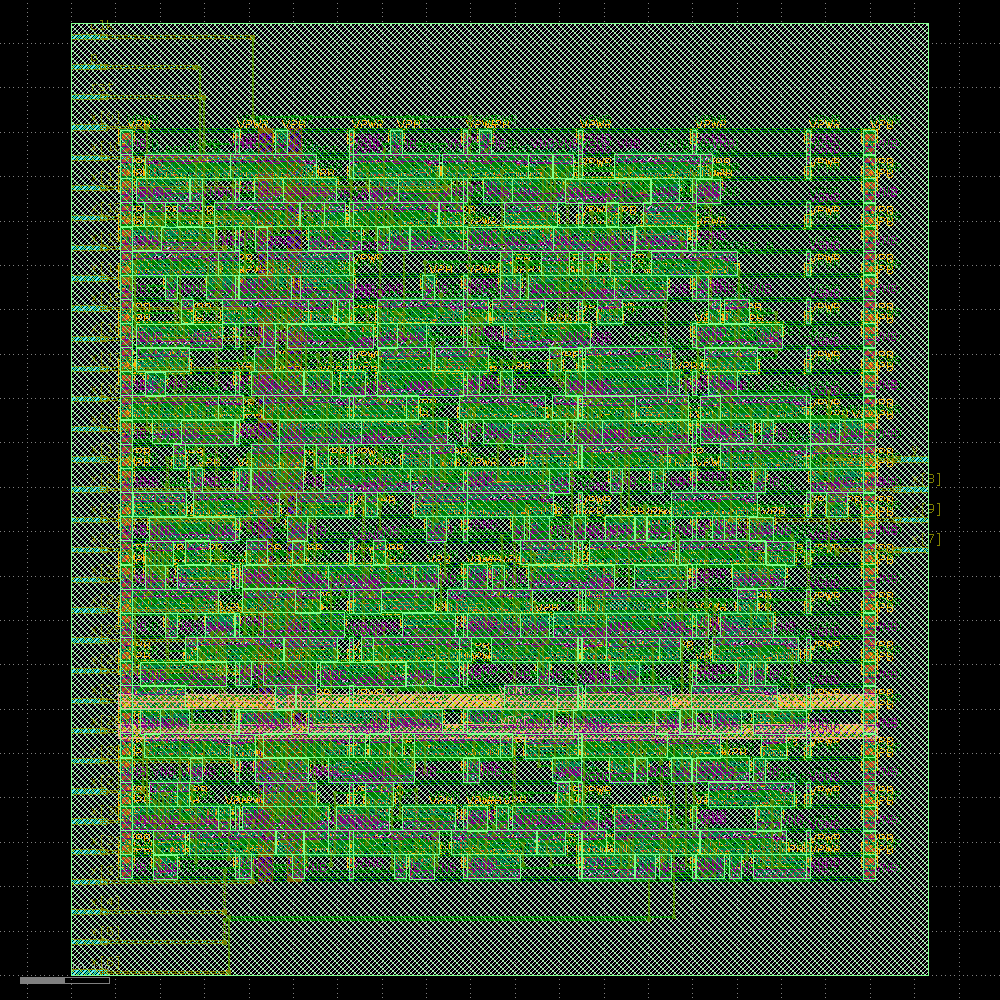

In [28]:
display(drt)

In [29]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion()
fill.start()

───────────────────────────────────────────────── Fill Insertion ──────────────────────────────────────────────────

Reading OpenROAD database at '/content/openlane_run/11-openroad-detailedrouting/spm.odb'…

Reading library file at '/content/openlane_run/tmp/45f5935fabb2422bb08adfae35a086bd.lib'…

Reading design constraints file at '/content/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a2111oi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__a21boi_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__and2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__buf_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s15_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__clkdlybuf4s18_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__fa_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_bleeder_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkbufkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_clkinvkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_12' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_3' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_6' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_decapkapwr_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso0p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1n_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputiso1p_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_inputisolatch_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrc_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_isobufsrckapwr_16' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_hl_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__lpflow_lsbuf_lh_isowell_tap_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__mux4_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o21ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__o311ai_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__or2_0' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probe_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__probec_p_8' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xor3_4' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_1' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_2' not found.

[WARNING STA-0376] cell 'sky130_fd_sc_hd__xnor3_4' not found.

sky130_fd_sc_hd__decap_8 sky130_fd_sc_hd__decap_6 sky130_fd_sc_hd__decap_4 sky130_fd_sc_hd__decap_3 
sky130_fd_sc_hd__fill*

[INFO DPL-0001] Placed 503 filler instances.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/12-openroad-fillinsertion/spm.odb'…

Writing netlist to '/content/openlane_run/12-openroad-fillinsertion/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/12-openroad-fillinsertion/spm.pnl.v'…

Writing layout to '/content/openlane_run/12-openroad-fillinsertion/spm.def'…

Writing timing constraints to '/content/openlane_run/12-openroad-fillinsertion/spm.sdc'…

{'nl': '/content/openlane_run/12-openroad-fillinsertion/spm.nl.v', 'pnl': '/content/openlane_run/12-openroad-fillinsertion/spm.pnl.v', 'def': '/content/openlane_run/12-openroad-fillinsertion/spm.def', 'lef': None, 'odb': '/content/openlane_run/12-openroad-fillinsertion/spm.odb', 'sdc': '/content/openlane_run/12-openroad-fillinsertion/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'metrics': {'design__instance__count': 395, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': 10363, 'design__core__area': Decimal('7175.63'), 'design__instance__area': Decimal('4007.59'), 'design__instance__count__stdcell': 395, 'design__instance__area__stdcell': Decimal('4007.59'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.5585'), 'design__instance__utilization__stdcell': Decimal('0.5585'), 'floorplan__design__io': 36, 'design__io__hpwl': 2622440, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wirelength__estimated': Decimal('4530.47'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'antenna__count': 0, 'route__net': 331, 'route__net__special': 2, 'route__drc_errors__iter:1': 127, 'route__wirelength__iter:1': 5451, 'route__drc_errors__iter:2': 14, 'route__wirelength__iter:2': 5380, 'route__drc_errors__iter:3': 16, 'route__wirelength__iter:3': 5350, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 5361, 'route__drc_errors': 0, 'route__wirelength': 5361, 'route__vias': 1843, 'route__vias__singlecut': 1843, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 1.11s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
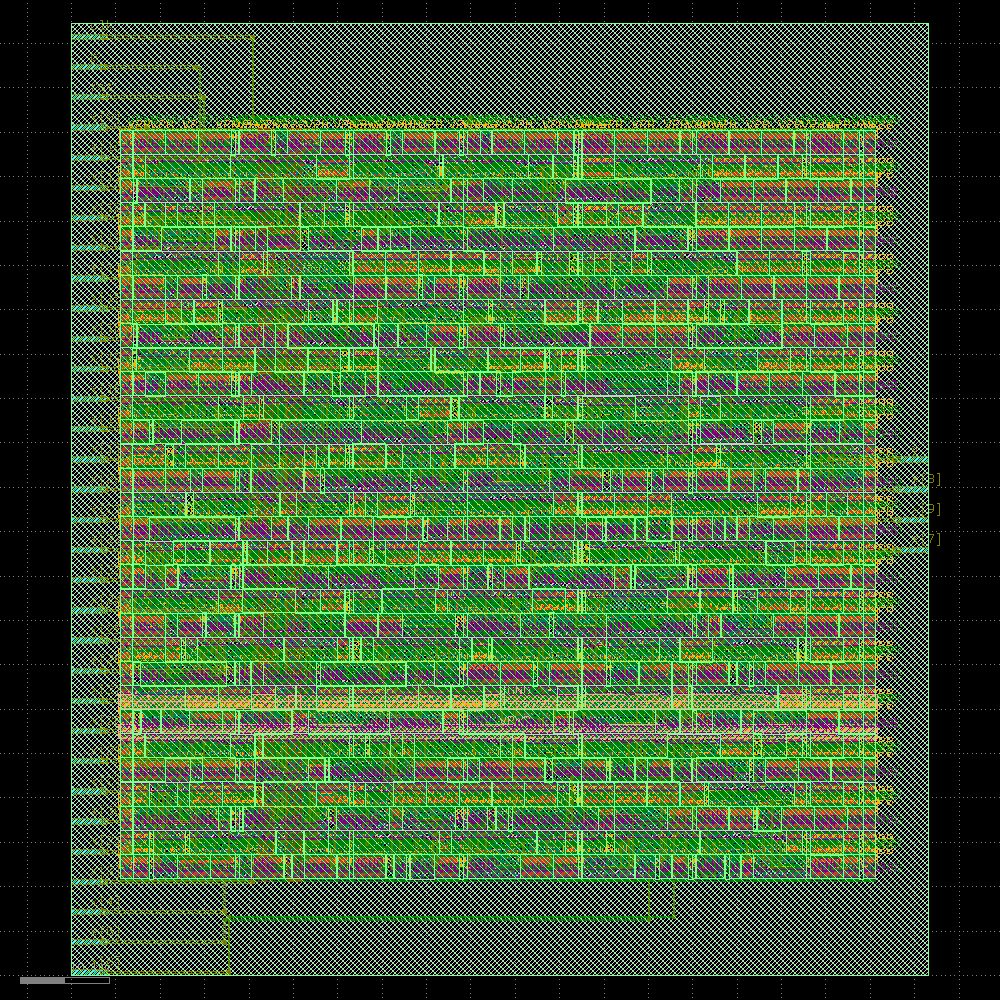

In [30]:
display(fill)

In [31]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut()
gds.start()

─────────────────────────────────────────── GDSII Stream Out (KLayout) ────────────────────────────────────────────

[INFO] Clearing cells…

[INFO] Merging GDS files…

/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds

[INFO] Copying top level cell 'spm'…

[INFO] Checking for missing GDS…

[INFO] All LEF cells have matching GDS cells.

[INFO] Writing out GDS '/content/openlane_run/13-klayout-streamout/spm.klayout.gds'…

[INFO] Done.

{'nl': '/content/openlane_run/12-openroad-fillinsertion/spm.nl.v', 'pnl': '/content/openlane_run/12-openroad-fillinsertion/spm.pnl.v', 'def': '/content/openlane_run/12-openroad-fillinsertion/spm.def', 'lef': None, 'odb': '/content/openlane_run/12-openroad-fillinsertion/spm.odb', 'sdc': '/content/openlane_run/12-openroad-fillinsertion/spm.sdc', 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': '/content/openlane_run/13-klayout-streamout/spm.gds', 'mag_gds': None, 'klayout_gds': '/content/openlane_run/13-klayout-streamout/spm.klayout.gds', 'json_h': None, 'metrics': {'design__instance__count': 395, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.58 107.3', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': 10363, 'design__core__area': Decimal('7175.63'), 'design__instance__area': Decimal('4007.59'), 'design__instance__count__stdcell': 395, 'design__instance__area__stdcell': Decimal('4007.59'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.5585'), 'design__instance__utilization__stdcell': Decimal('0.5585'), 'floorplan__design__io': 36, 'design__io__hpwl': 2622440, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wirelength__estimated': Decimal('4530.47'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'antenna__count': 0, 'route__net': 331, 'route__net__special': 2, 'route__drc_errors__iter:1': 127, 'route__wirelength__iter:1': 5451, 'route__drc_errors__iter:2': 14, 'route__wirelength__iter:2': 5380, 'route__drc_errors__iter:3': 16, 'route__wirelength__iter:3': 5350, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 5361, 'route__drc_errors': 0, 'route__wirelength': 5361, 'route__vias': 1843, 'route__vias__singlecut': 1843, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 2.42s
#### Views updated:
* GDSII Stream
* GDSII Stream (KLayout)
#### Preview:
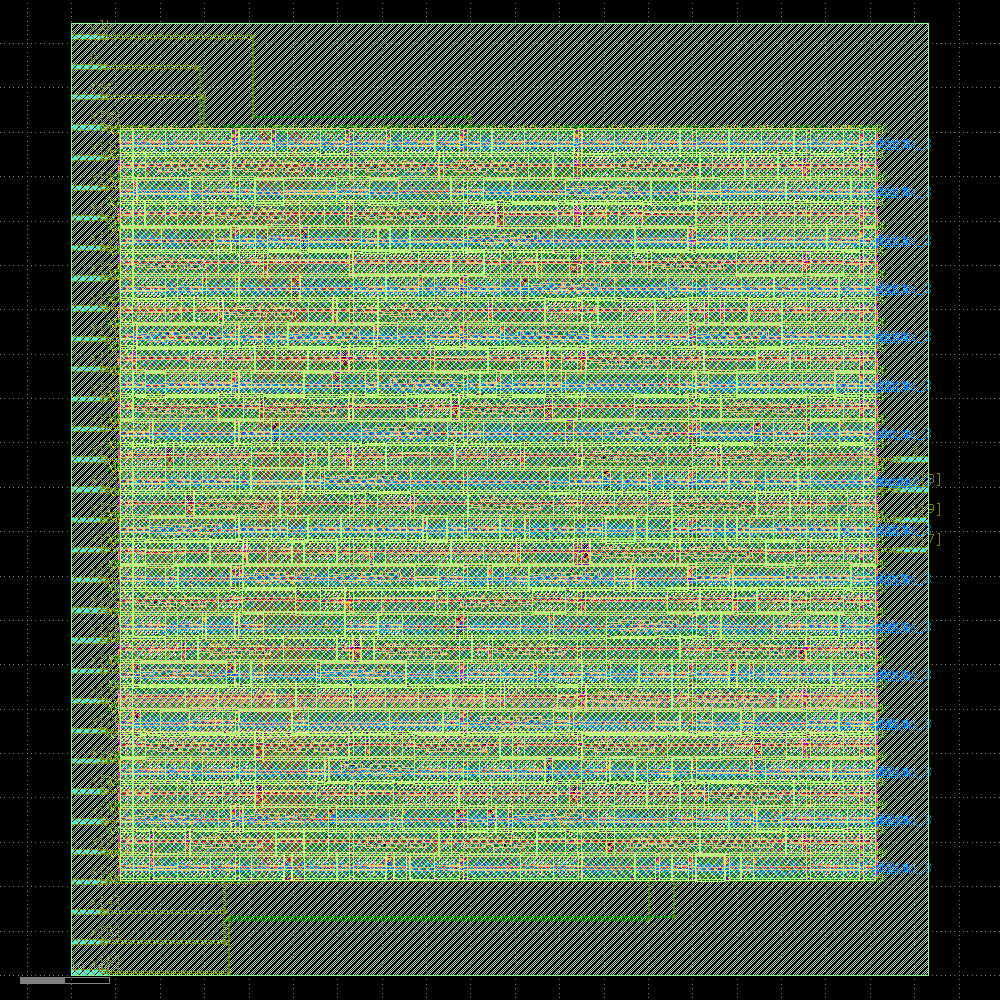

In [32]:
display(gds)